In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import os
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
from prophet import Prophet
from prophet.plot import plot_components

# part 1

# Data appload

In [3]:
df_weather = pd.read_csv("DailyDelhiClimateFull.csv")
df_weather['date'] = pd.to_datetime(df_weather['date'], dayfirst=True)

#In Kaggle the Train data was up to 1/1/2017 and Test from 1/1/17
df_weather_train = df_weather[df_weather['date'] < pd.Timestamp('2017-01-01')].copy()
df_weather_train.head()

date   meantemp   humidity  wind_speed  meanpressure
0 2013-01-01  10.000000  84.500000    0.000000   1015.666667
1 2013-01-02   7.400000  92.000000    2.980000   1017.800000
2 2013-01-03   7.166667  87.000000    4.633333   1018.666667
3 2013-01-04   8.666667  71.333333    1.233333   1017.166667
4 2013-01-05   6.000000  86.833333    3.700000   1016.500000

In [4]:
#In Kaggle the Train data was up to 1/1/2017 and Test from 1/1/17
df_weather_test = df_weather[df_weather['date'] >= pd.Timestamp('2017-01-01')].copy()
df_weather_test.head()

date   meantemp   humidity  wind_speed  meanpressure
1461 2017-01-01  15.913043  85.869565    2.743478     59.000000
1462 2017-01-02  18.500000  77.222222    2.894444   1018.277778
1463 2017-01-03  17.111111  81.888889    4.016667   1018.333333
1464 2017-01-04  18.700000  70.050000    4.545000   1015.700000
1465 2017-01-05  18.388889  74.944444    3.300000   1014.333333

# Data display

In [5]:
df_weather_train['Year'] = df_weather_train['date'].dt.year

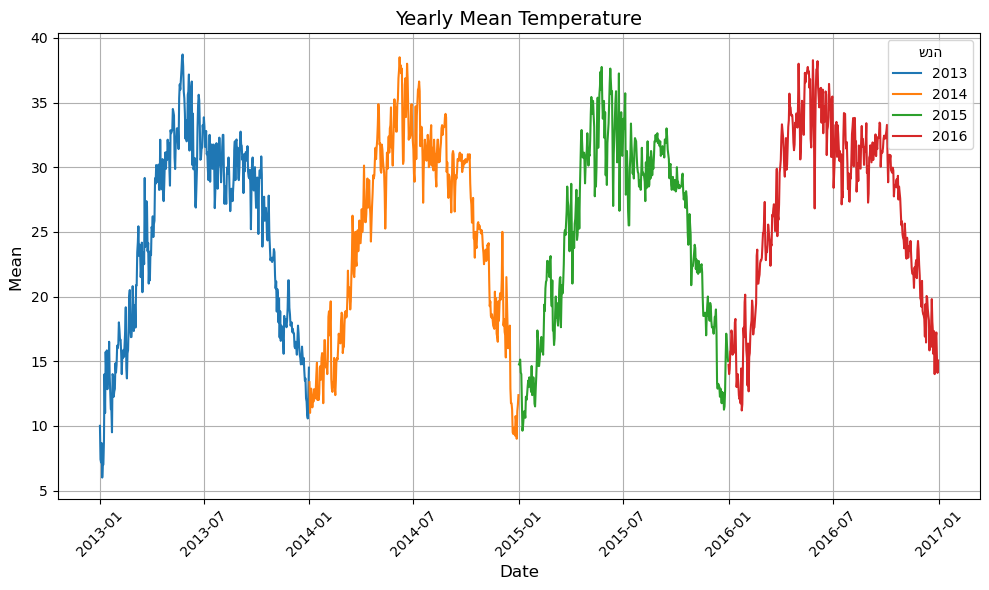

In [6]:
plt.figure(figsize=(10, 6))

for year in df_weather_train['Year'].unique():
    df_year = df_weather_train[df_weather_train['Year'] == year]
    plt.plot(df_year['date'], df_year['meantemp'], label=str(year))

plt.title('Yearly Mean Temperature', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Mean ', fontsize=12)

plt.legend(title='שנה')

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
correlation_matrix = df_weather_train.corr()
correlation_matrix

date  meantemp  humidity  wind_speed  meanpressure      Year
date          1.000000  0.133293 -0.052962   -0.023007      0.013805  0.968246
meantemp      0.133293  1.000000 -0.570510    0.305011     -0.038838  0.107369
humidity     -0.052962 -0.570510  1.000000   -0.372565      0.001693 -0.075222
wind_speed   -0.023007  0.305011 -0.372565    1.000000     -0.020658  0.017963
meanpressure  0.013805 -0.038838  0.001693   -0.020658      1.000000  0.022498
Year          0.968246  0.107369 -0.075222    0.017963      0.022498  1.000000

# Decomposition

In [8]:
def create_graphs(df, parm, period = 365):
  index_end = df.shape[0]

  # Create the figure and subplots
  fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
  SES = seasonal_decompose(df.head(index_end), period=period, model='additive')

  # SES.observed
  # SES.trend
  # SES.seasonal
  # SES.resid


  # # Plot the data on each subplot
  axs[0][0].plot(df.index[:index_end], SES.observed)
  axs[0][1].plot(df.index[:index_end], SES.trend)
  axs[1][0].plot(df.index[:index_end], SES.seasonal)
  axs[1][1].plot(df.index[:index_end], SES.resid)

  # # Add suptitle for the entire figure
  fig.suptitle(f'Daily {parm} , Delhi', fontsize=16)

  # Add titles and labels for each subplot
  axs[0][0].set_title('Observed')
  axs[0][0].set_ylabel(f'{parm}')
  axs[0][1].set_title('Trend')
  axs[0][1].set_ylabel('Trend')
  axs[1][0].set_title('Seasonal')
  axs[1][0].set_ylabel('Seasonal')
  axs[1][1].set_title('Residual')
  axs[1][1].set_ylabel('Residual')
  axs[1][1].set_xlabel('Date')

  # Show the plot
  plt.tight_layout()
  plt.show()

In [9]:
period = 365

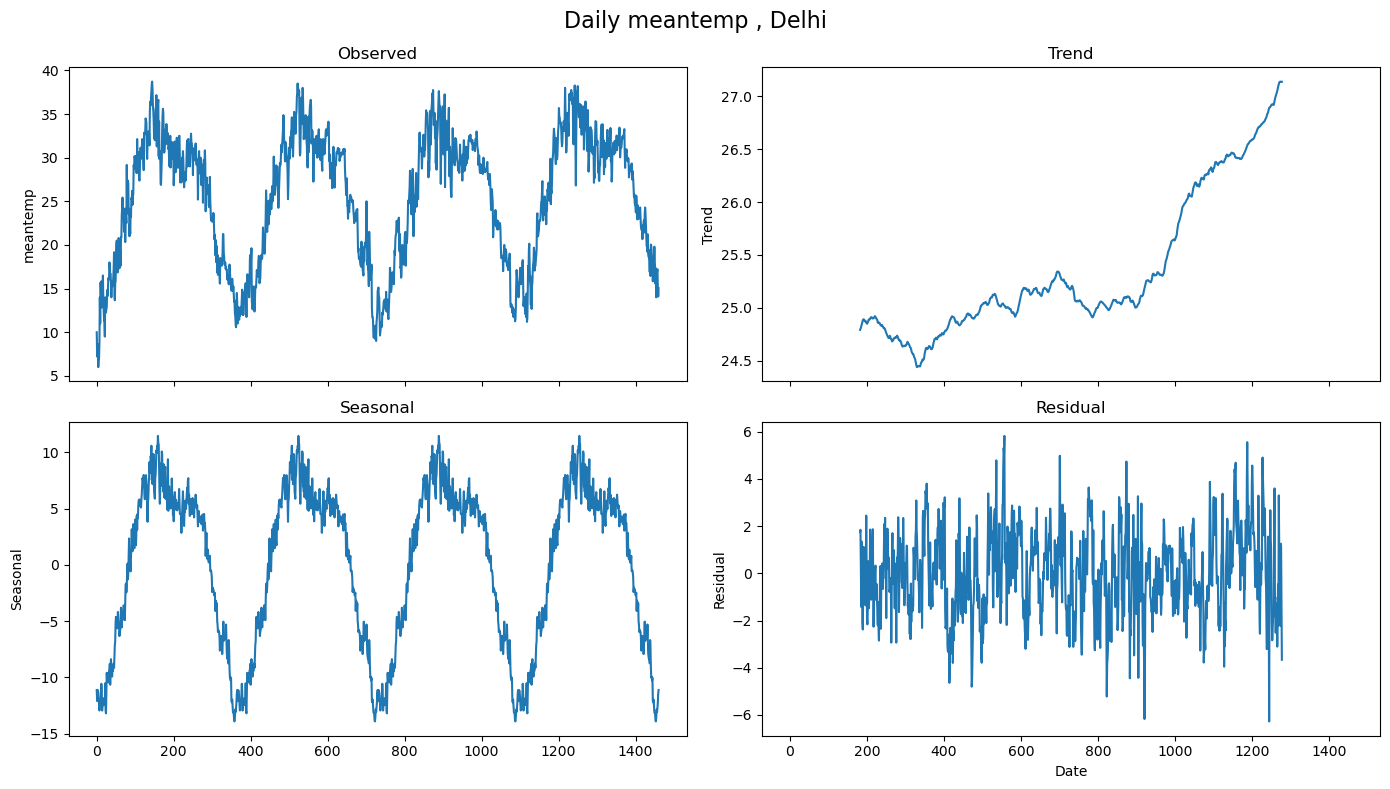

In [10]:
create_graphs(df_weather_train['meantemp'], 'meantemp',period=period)

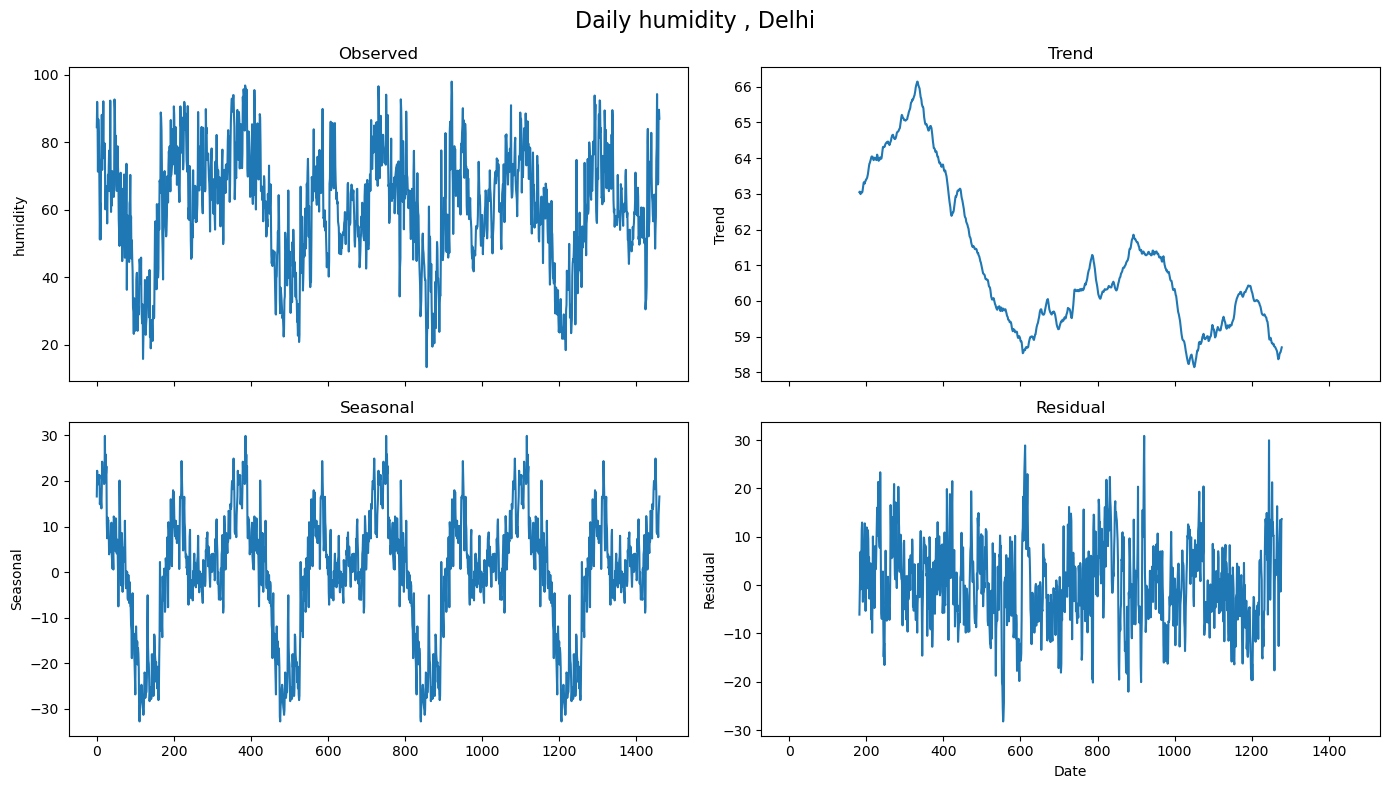

In [11]:
create_graphs(df_weather_train['humidity'], 'humidity',period=period)

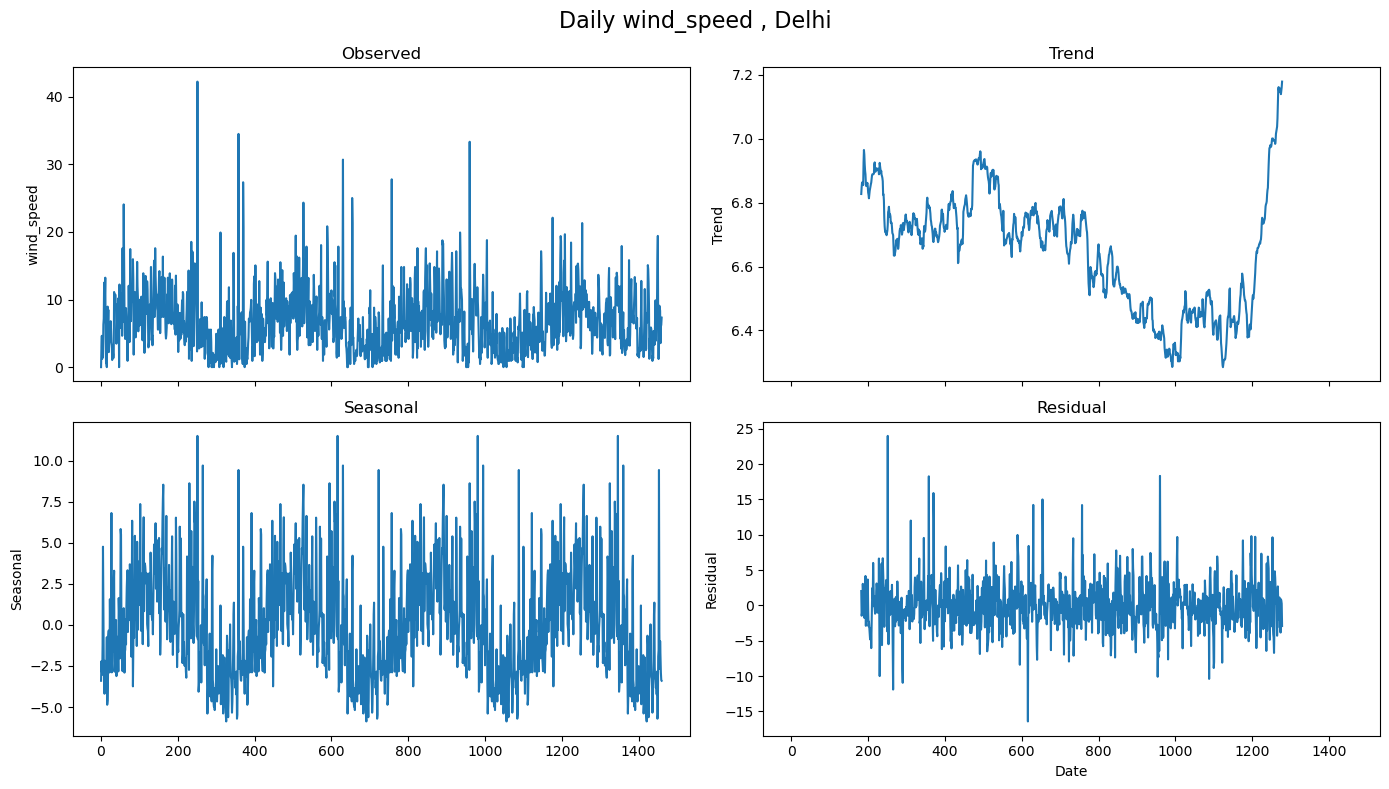

In [12]:
create_graphs(df_weather_train['wind_speed'], 'wind_speed',period=period)

.(meantemp)בניתוח הנתונים, נשתמש במשתנה טמפרטורה ממוצעת כמשתנה העיקרי







משתנים אקסוגנים :


1.   Humidity
2.   wind speed



# For choosing the exogenous data we'll look at correlation



In [13]:
correlation_matrix = df_weather_train.corr()
correlation_matrix

date  meantemp  humidity  wind_speed  meanpressure      Year
date          1.000000  0.133293 -0.052962   -0.023007      0.013805  0.968246
meantemp      0.133293  1.000000 -0.570510    0.305011     -0.038838  0.107369
humidity     -0.052962 -0.570510  1.000000   -0.372565      0.001693 -0.075222
wind_speed   -0.023007  0.305011 -0.372565    1.000000     -0.020658  0.017963
meanpressure  0.013805 -0.038838  0.001693   -0.020658      1.000000  0.022498
Year          0.968246  0.107369 -0.075222    0.017963      0.022498  1.000000

---


# Part 2


In [14]:
# Setting the date to be the index for the graphs
df_weather_graphs = df_weather_train.copy()
df_weather_graphs.set_index('date',inplace=True)

In [15]:
def ADFTest(data):
  # Perform Augmented Dickey-Fuller Test
  adf_result = adfuller(data, autolag='AIC')

  # Print results
  print("ADF Statistic:", adf_result[0])
  print("p-value:", adf_result[1])
  print("Critical Values:", adf_result[4])

  # Interpretation
  if adf_result[1] < 0.05:
      print("The time series is **stationary** (reject null hypothesis).")
  else:
      print("The time series is **not stationary** (fail to reject null). Consider differencing.")

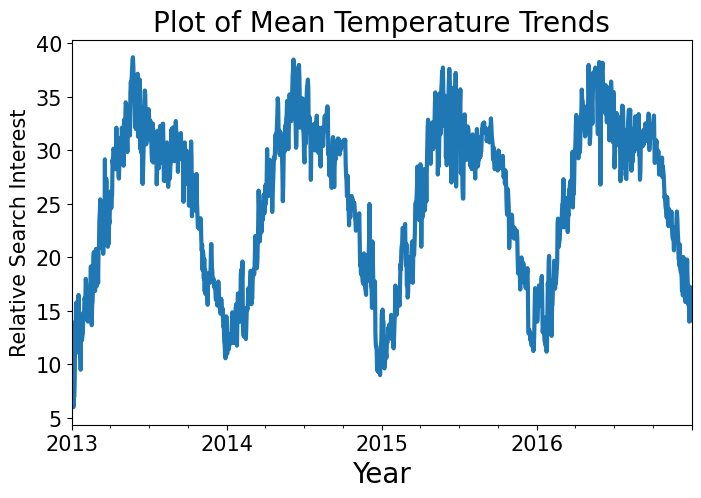

In [16]:
# Looking at the original series to see the need for differentiation
temperature = df_weather_graphs['meantemp']
temperature.plot(figsize=(8,5), linewidth=3, fontsize=15)
plt.title("Plot of Mean Temperature Trends",fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Relative Search Interest', fontsize=15);

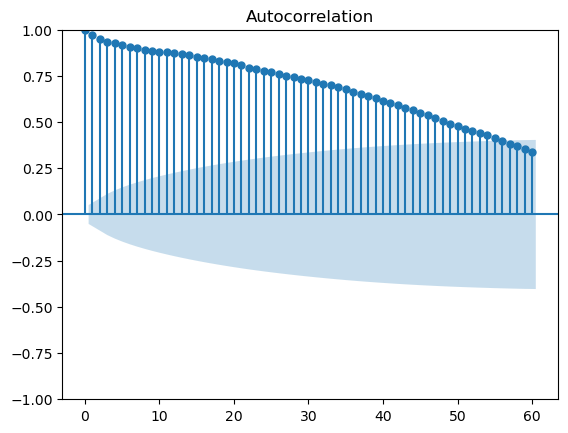

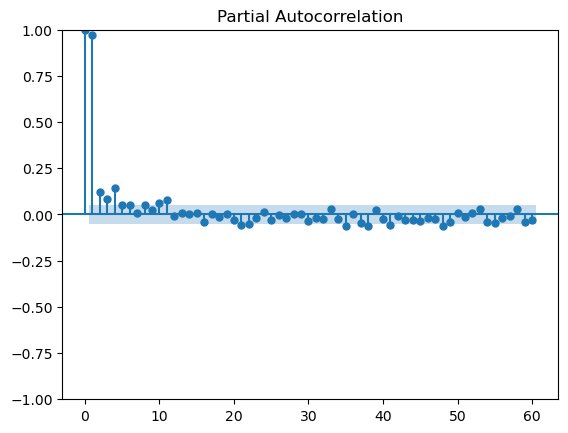

In [17]:
tsaplots.plot_acf(temperature,lags=60);
tsaplots.plot_pacf(temperature,lags=60);

In [18]:
# ADF Test
ADFTest(temperature)

ADF Statistic: -2.155565227446428
p-value: 0.22276593986733612
Critical Values: {'1%': -3.4348678719530934, '5%': -2.863535337271721, '10%': -2.5678323015457787}
The time series is **not stationary** (fail to reject null). Consider differencing.


We can see the the ACF are declining slowly which shows that the series isn't stationary, as the ADF test shows.<br>
Almost 60 days previos to the k-th day have a correlation to k-th day which is a sign for a strong trend, same as we saw in the seasonal decompocition. <br>
From the PACF precaption we see that the first lag is the most segnificant even that there are additional lags with influence.

For the above reasons we will look at differantion of the series.

#### Day apart

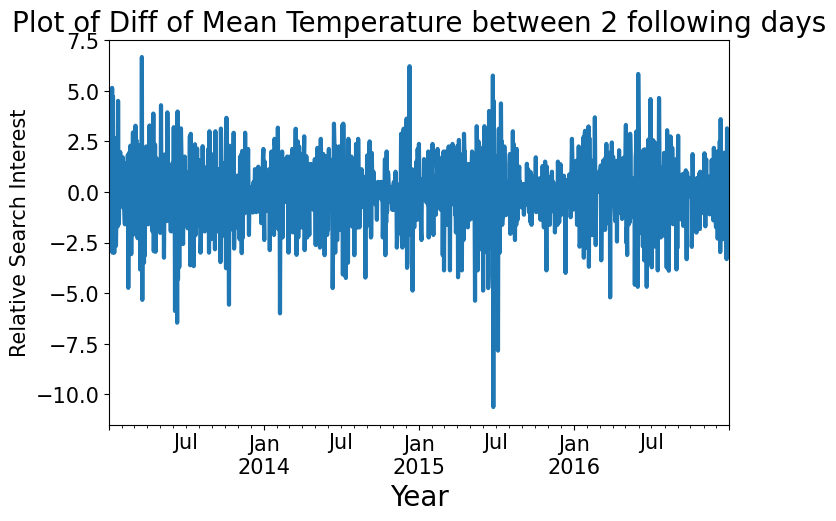

In [19]:
# Doing diff between 2 following days - we won't do any aggrigation due to data size limitation
temp_diff_1 = temperature.diff(1).dropna()
temp_diff_1.plot(figsize=(8,5), linewidth=3, fontsize=15)
plt.title("Plot of Diff of Mean Temperature between 2 following days",fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Relative Search Interest', fontsize=15);
plt.show()

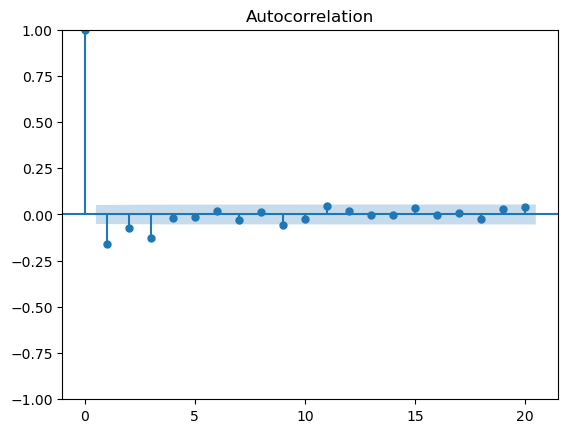

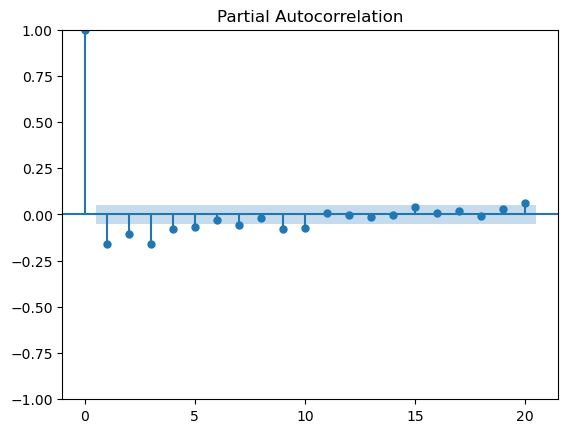

In [20]:
tsaplots.plot_acf(temp_diff_1,lags=20);
tsaplots.plot_pacf(temp_diff_1,lags=20);

We can see that most of the trend was removed as only the first 3 are significant in the ACF but also it aims to zero. <br>
The PACF has the first 5 to be the most segnificant and it is also aiming to zero.

In [21]:
# ADF Test
ADFTest(temp_diff_1)

ADF Statistic: -16.520440592332687
p-value: 2.0666135559464958e-29
Critical Values: {'1%': -3.4348678719530934, '5%': -2.863535337271721, '10%': -2.5678323015457787}
The time series is **stationary** (reject null hypothesis).


#### Difference of a month between differnce of 2 days

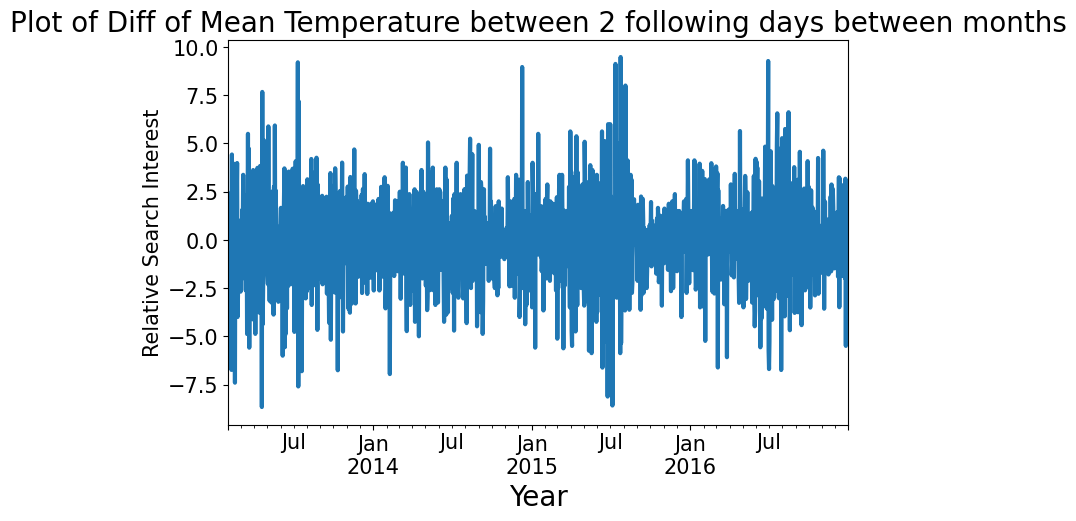

In [22]:
# Doing diff between 2 following days - we won't do any aggrigation due to data size limitation
temp_diff_1_30 = temperature.diff(1).dropna().diff(30).dropna()
temp_diff_1_30.plot(figsize=(8,5), linewidth=3, fontsize=15)
plt.title("Plot of Diff of Mean Temperature between 2 following days between months",fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Relative Search Interest', fontsize=15);
plt.show()

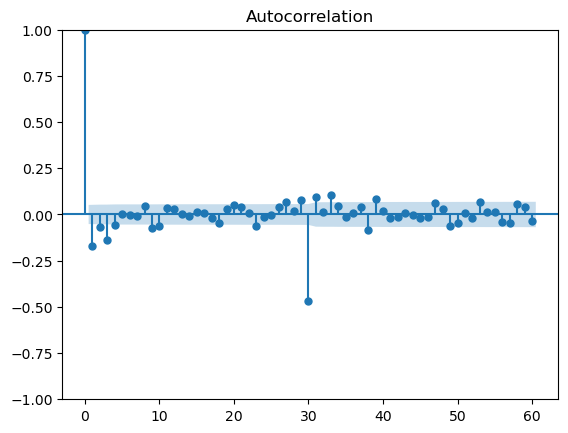

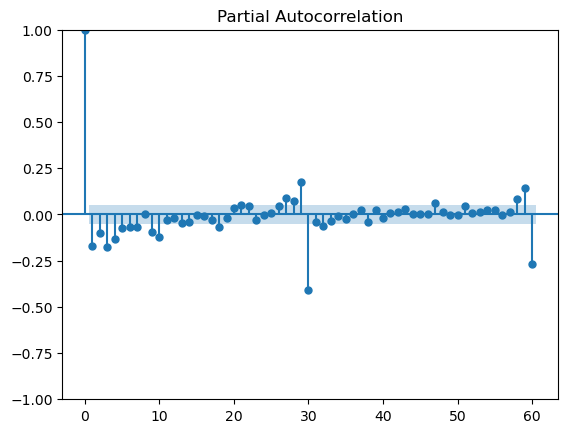

In [23]:
tsaplots.plot_acf(temp_diff_1_30,lags=60);
tsaplots.plot_pacf(temp_diff_1_30,lags=60);

In [24]:
# ADF Test
ADFTest(temp_diff_1_30)

ADF Statistic: -17.8917581282967
p-value: 2.9758344973667123e-30
Critical Values: {'1%': -3.4349634933241084, '5%': -2.8635775363009244, '10%': -2.5678547733584605}
The time series is **stationary** (reject null hypothesis).


#### Year apart

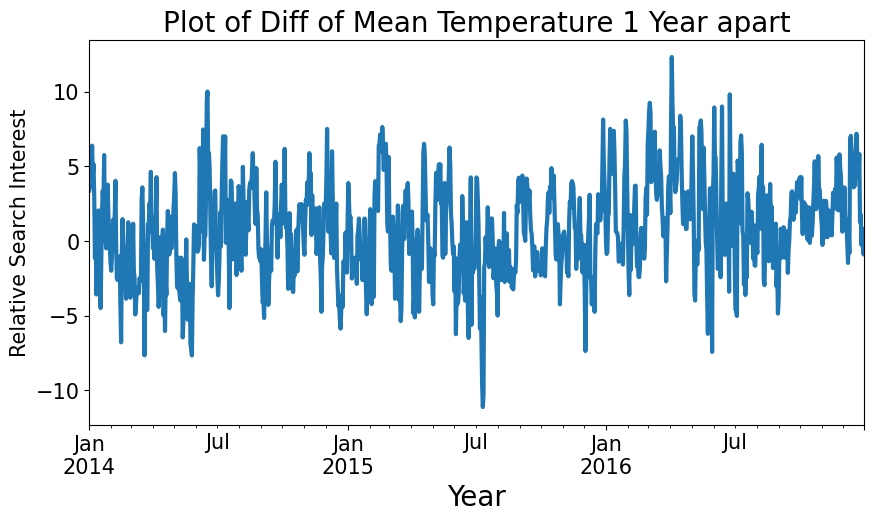

In [25]:
# Doing diff between 2 days a year seperate
temp_diff_365 = temperature.diff(365).dropna()
temp_diff_365.plot(figsize=(10,5), linewidth=3, fontsize=15)
plt.title("Plot of Diff of Mean Temperature 1 Year apart",fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Relative Search Interest', fontsize=15);
plt.show()

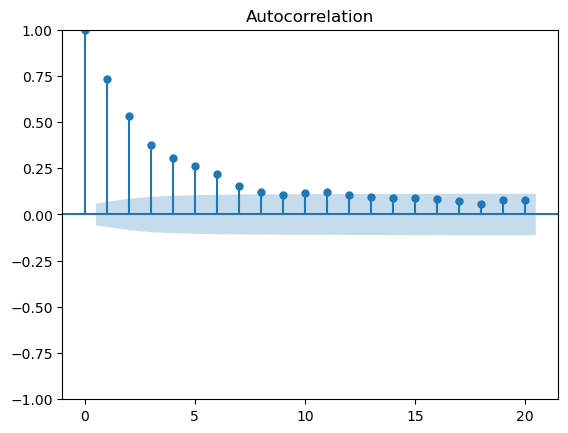

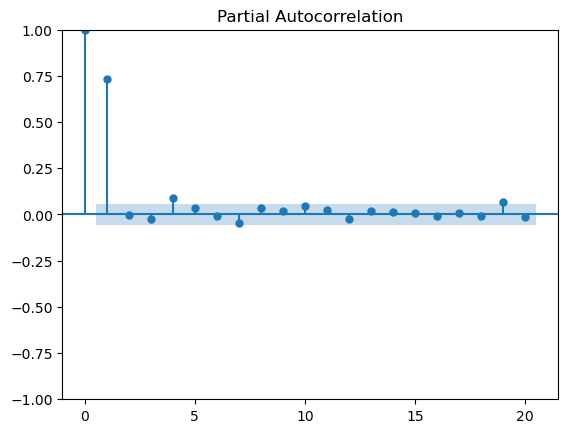

In [26]:
tsaplots.plot_acf(temp_diff_365,lags=20);
tsaplots.plot_pacf(temp_diff_365,lags=20);

From the ACF we see the trend wasn't removed and it doesn't decreasing to zero.<br>
From the PACF we see the first lag to be important and that it aims to decrease to zero.

In [27]:
# ADF Test
ADFTest(temp_diff_365)

ADF Statistic: -10.084459784462185
p-value: 1.1652774953984939e-17
Critical Values: {'1%': -3.436352507699052, '5%': -2.86419037625175, '10%': -2.56818114683546}
The time series is **stationary** (reject null hypothesis).


In [28]:
def calculate_mean_and_var(test_values, forecast):
    error = test_values - forecast.values
    error_mean = np.mean(error)
    mse = np.mean(np.power(error,2))
    error_variance = np.var(error)

    print(f"Mean of the Error: {error_mean}")
    print(f"MSE: {mse}")
    print(f"Variance of the Error: {error_variance}")
    return (error_mean, error_variance, mse)

## Sarima:

We have a few model that we will look at and we will take the one with the best BIC.<br>
An important note is that we can't aggrigate our data to weeks or month since the data size is 1462 days. This lead to some of the models to run longer that other, mainly the model with period of 365.

In [29]:
def SarimaSummary(data, order, seasonal_order):
  model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
  model = model.fit(disp=False)
  print(model.summary())
  model.plot_diagnostics(lags=20,figsize=(15, 12))
  plt.show()
  return model

In [30]:
# model_107_010365 = SarimaSummary(temperature, (1,0,7), (0,1,0,365))

In [31]:
# model_117_010365 = SarimaSummary(temperature, (1,1,7), (0,1,0,365))

In [32]:
# model_117_110365 = SarimaSummary(temperature, (1,1,7), (1,1,0,365))

In [33]:
# model_100_010365 = SarimaSummary(temperature, (1,0,0), (0,1,0,365))

In [34]:
# model_100_110365 = SarimaSummary(temperature, (1,0,0), (1,1,0,365))

C:\Users\eliza\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\eliza\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1461
Model:              SARIMAX(10, 1, 3)   Log Likelihood               -2751.612
Date:                Thu, 03 Apr 2025   AIC                           5531.225
Time:                        21:03:13   BIC                           5605.231
Sample:                    01-01-2013   HQIC                          5558.832
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0271      0.523      0.052      0.959      -0.999       1.053
ar.L2         -0.4739      0.287     -1.652      0.099      -1.036       0.088
ar.L3         -0.0051      0.286     -0.018      0.9

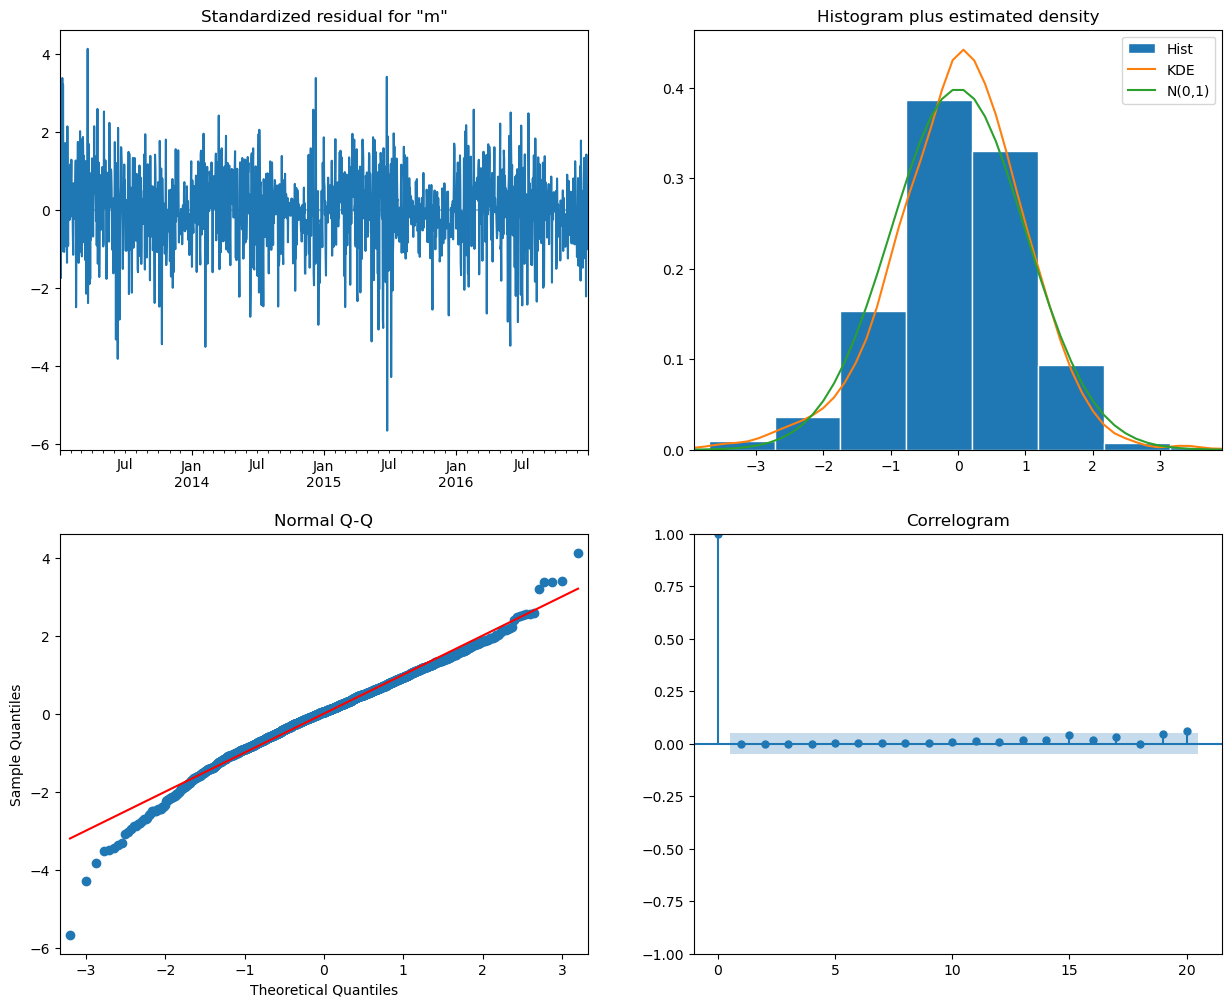

In [35]:
model_1013_0000 = SarimaSummary(temperature, (10,1,3), (0,0,0,0))

C:\Users\eliza\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\eliza\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1461
Model:               SARIMAX(9, 1, 0)   Log Likelihood               -2755.732
Date:                Thu, 03 Apr 2025   AIC                           5531.464
Time:                        21:03:14   BIC                           5584.325
Sample:                    01-01-2013   HQIC                          5551.183
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2171      0.021    -10.174      0.000      -0.259      -0.175
ar.L2         -0.1663      0.024     -6.840      0.000      -0.214      -0.119
ar.L3         -0.2011      0.027     -7.550      0.0

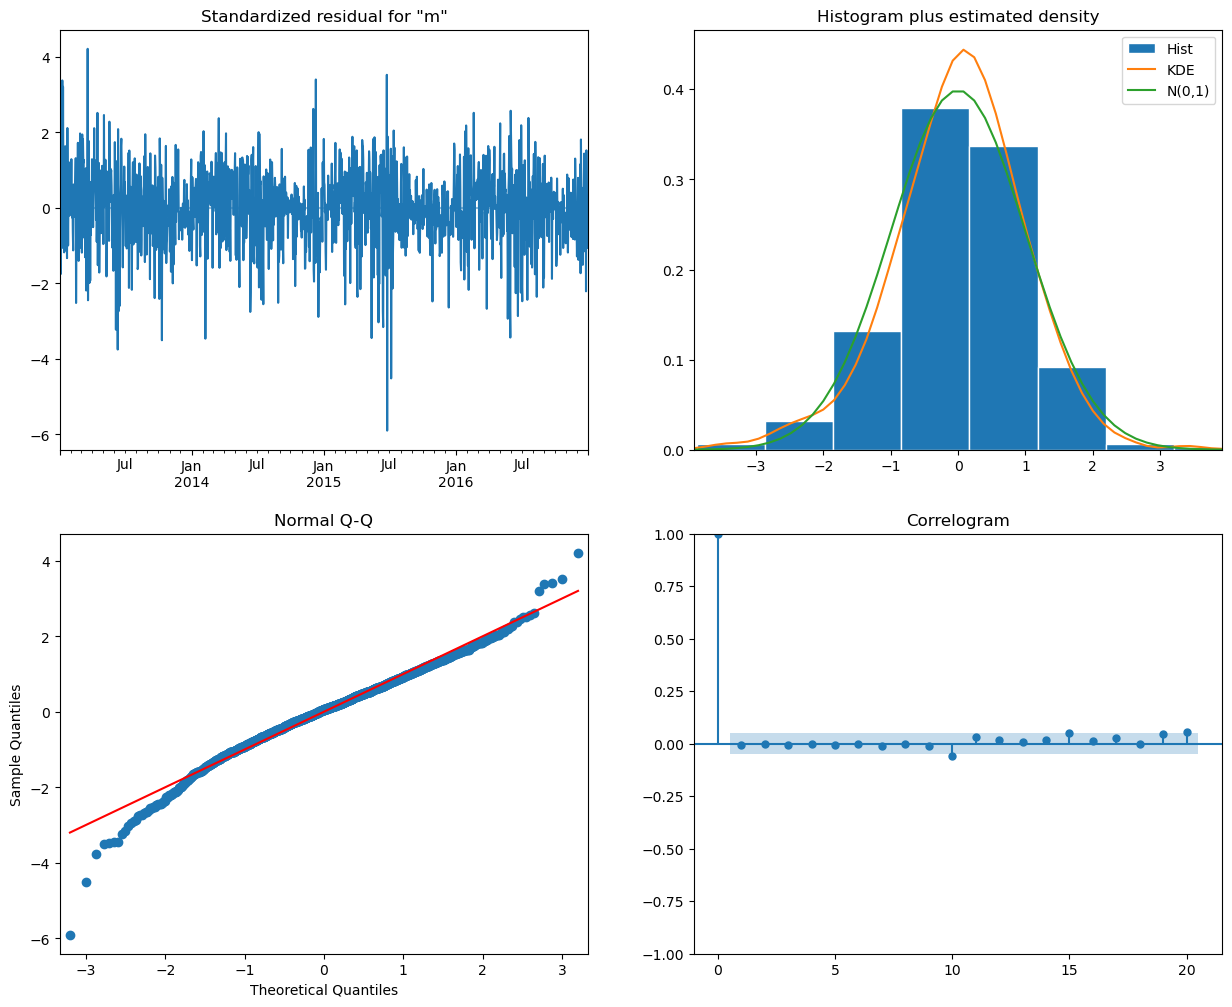

In [36]:
model_910_0000 = SarimaSummary(temperature, (9,1,0), (0,0,0,0))

C:\Users\eliza\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\eliza\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\eliza\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\eliza\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\eliza\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1461
Model:               SARIMAX(4, 1, 3)   Log Likelihood               -2743.285
Date:                Thu, 03 Apr 2025   AIC                           5502.570
Time:                        21:03:17   BIC                           5544.860
Sample:                    01-01-2013   HQIC                          5518.346
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7040      0.032     21.864      0.000       0.641       0.767
ar.L2          0.9932      0.038     26.380      0.000       0.919       1.067
ar.L3         -0.6936      0.028    -24.931      0.0

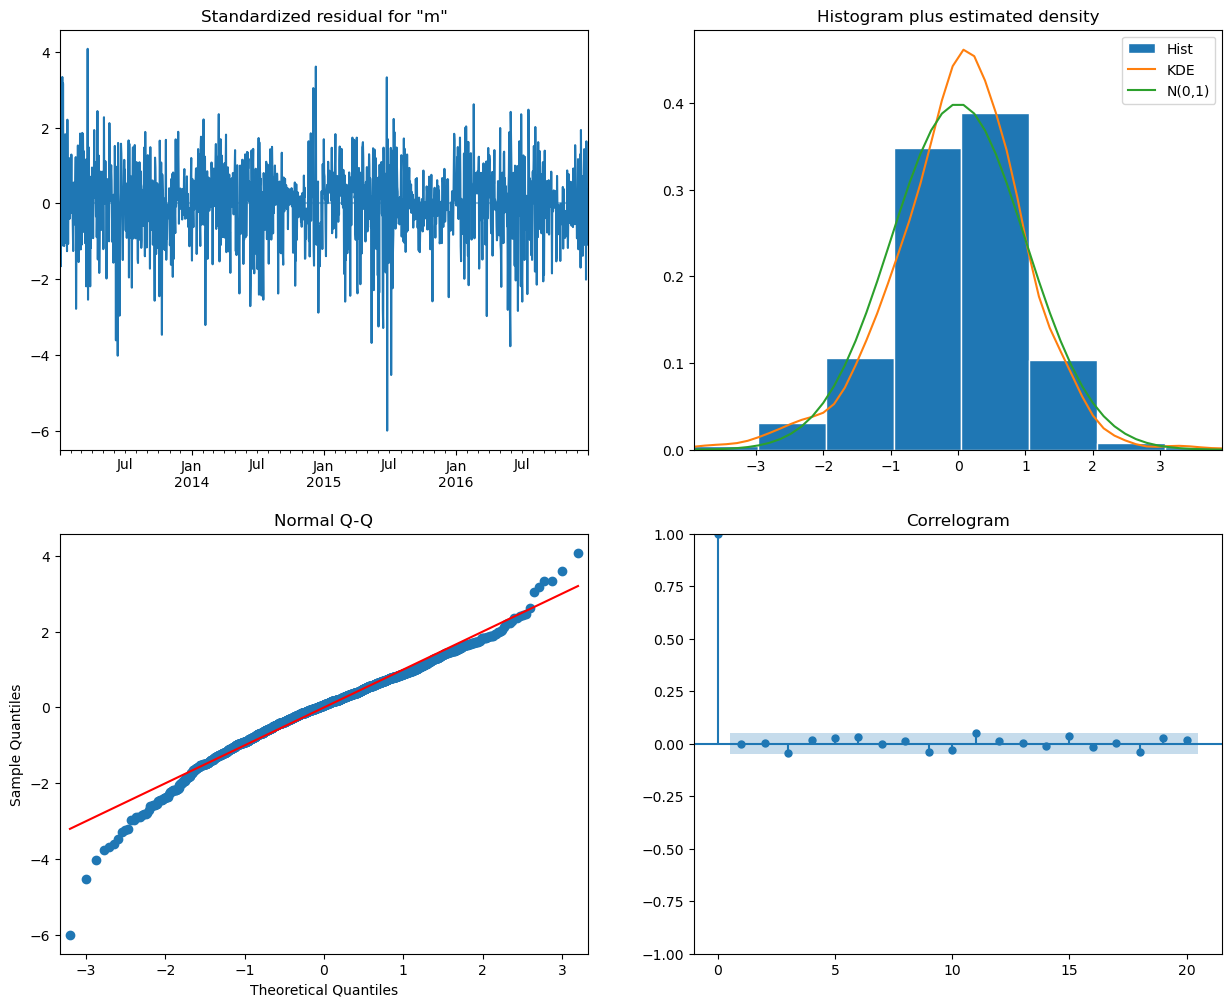

In [37]:
model_413_0000 = SarimaSummary(temperature, (4,1,3), (0,0,0,0))

In [38]:
# model_1014_11190 = SarimaSummary(temperature, (1,1,1), (1,1,1,90)) # יותר מ15 דקות

C:\Users\eliza\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\eliza\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                            meantemp   No. Observations:                 1461
Model:             SARIMAX(10, 1, 1)x(1, 1, 1, 30)   Log Likelihood               -2754.226
Date:                             Thu, 03 Apr 2025   AIC                           5536.453
Time:                                     21:05:20   BIC                           5610.169
Sample:                                 01-01-2013   HQIC                          5563.980
                                      - 12-31-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3067      0.275     -1.114      0.265      -0.846       0.233
ar.L2         -0.1830      

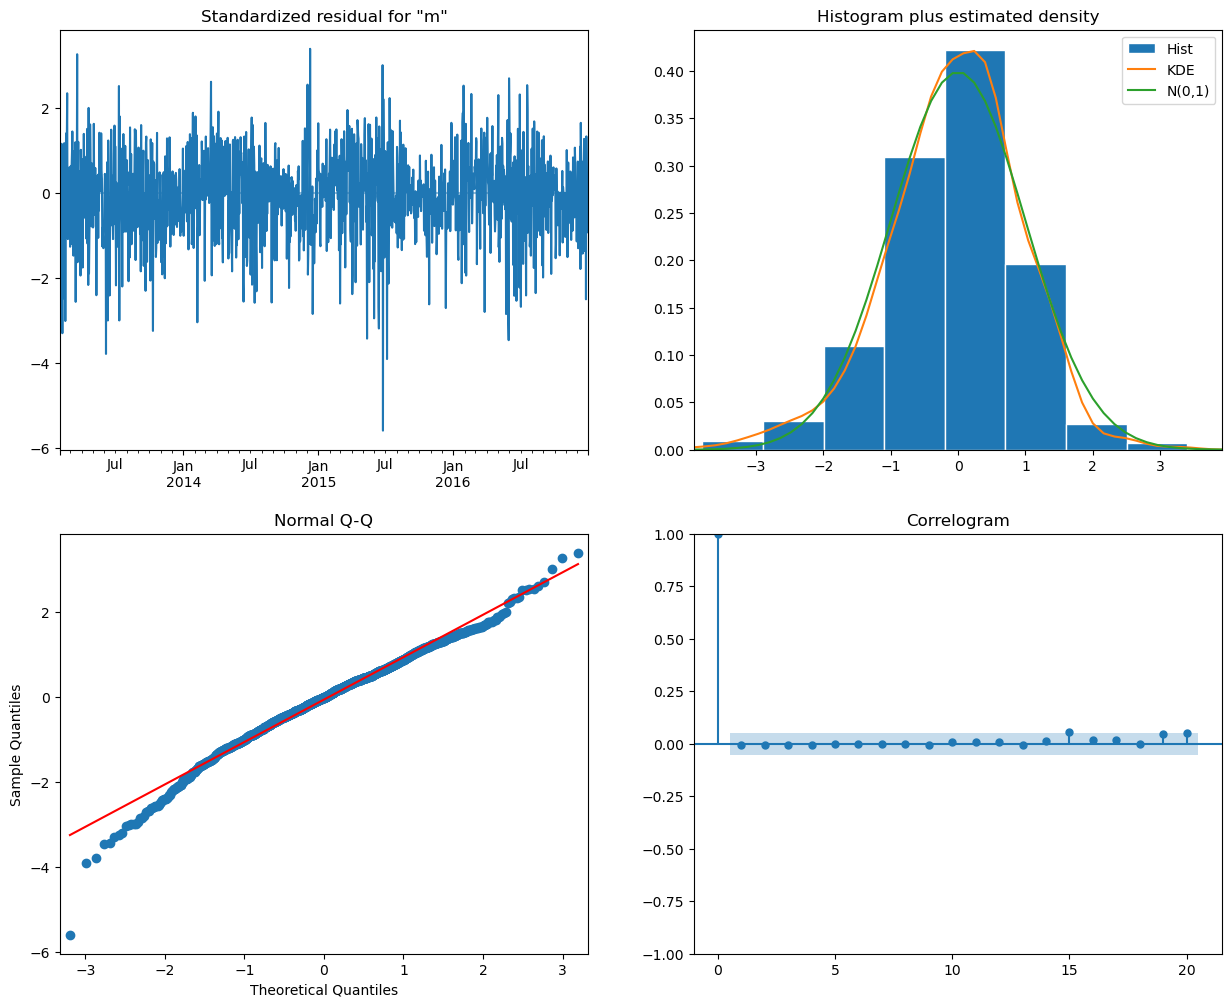

In [39]:
model_1011_11130 = SarimaSummary(temperature, (10,1,1), (1,1,1,30))

C:\Users\eliza\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\eliza\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                           meantemp   No. Observations:                 1461
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 30)   Log Likelihood               -2764.914
Date:                            Thu, 03 Apr 2025   AIC                           5539.828
Time:                                    21:06:31   BIC                           5566.155
Sample:                                01-01-2013   HQIC                          5549.659
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5780      0.044     13.200      0.000       0.492       0.664
ma.L1         -0.8101      0.034   

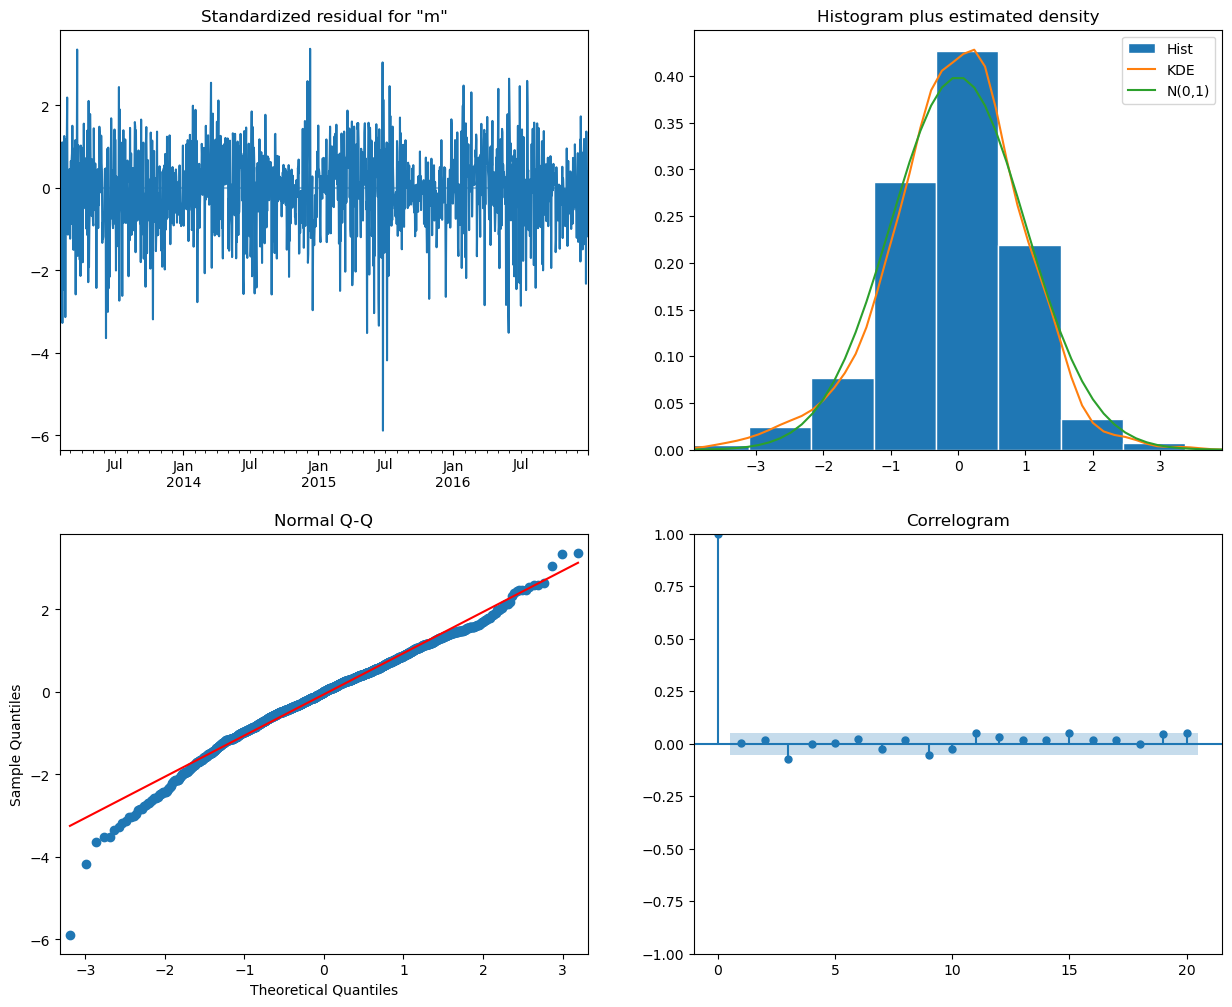

In [40]:
model_111_11130 = SarimaSummary(temperature, (1,1,1), (1,1,1,30))

C:\Users\eliza\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\eliza\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\eliza\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\eliza\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\eliza\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1461
Model:               SARIMAX(5, 1, 3)   Log Likelihood               -2743.446
Date:                Thu, 03 Apr 2025   AIC                           5504.892
Time:                        21:06:37   BIC                           5552.468
Sample:                    01-01-2013   HQIC                          5522.640
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7054      0.040     17.460      0.000       0.626       0.785
ar.L2          0.9859      0.056     17.763      0.000       0.877       1.095
ar.L3         -0.6928      0.037    -18.478      0.0

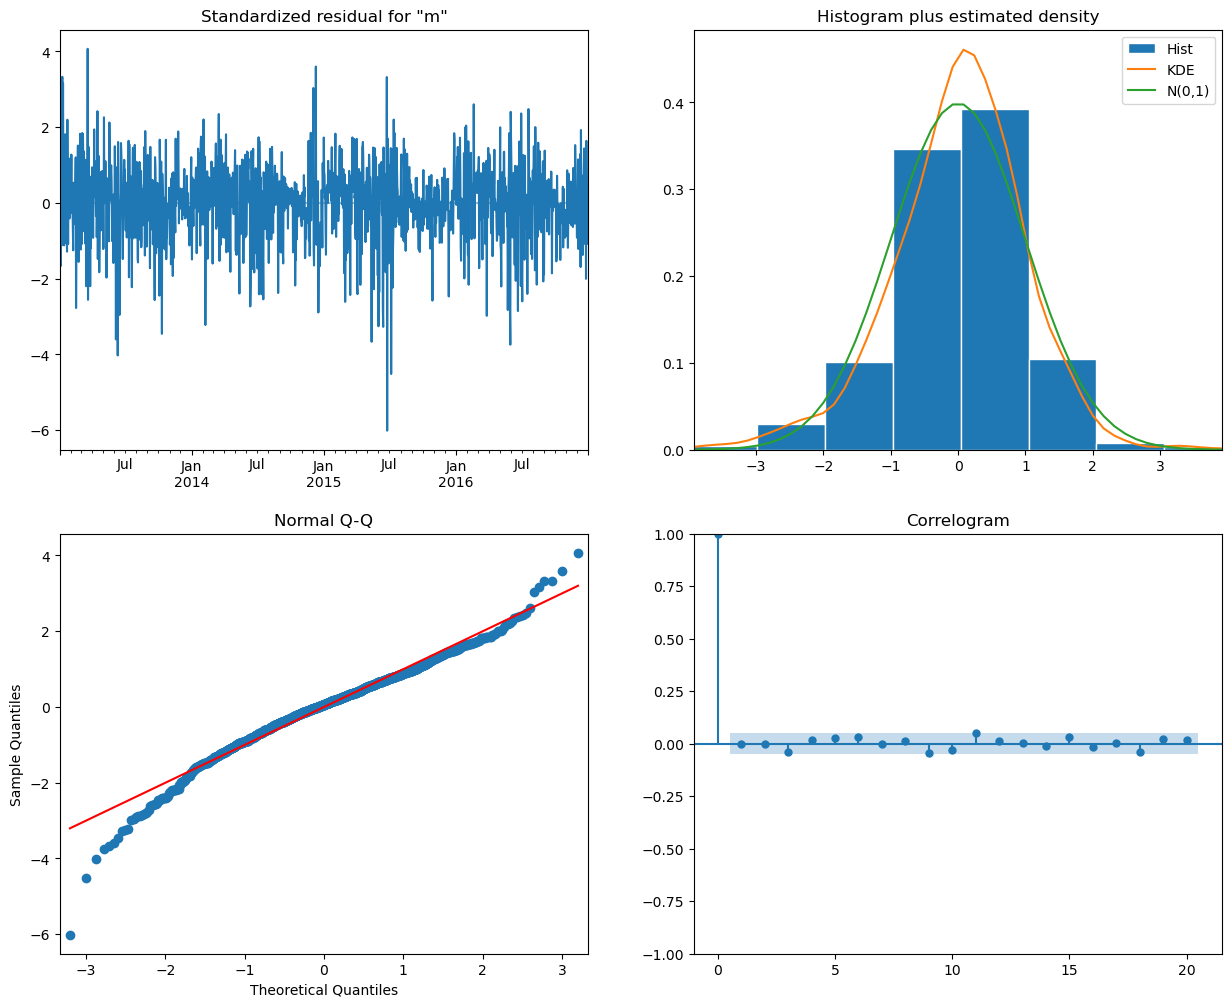

In [41]:
model_513_0000 = SarimaSummary(temperature, (5,1,3), (0,0,0,0))

In [42]:
# add for loop to show what model was choosen (bic)
all_models = [model_1013_0000,model_513_0000, model_910_0000,
              model_413_0000,model_111_11130,model_1011_11130]
min_bic = np.inf
chosen_model = None
for model in all_models:
  if model.bic < min_bic:
    min_bic = model.bic
    chosen_model = model

print(chosen_model.summary())

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1461
Model:               SARIMAX(4, 1, 3)   Log Likelihood               -2743.285
Date:                Thu, 03 Apr 2025   AIC                           5502.570
Time:                        21:06:39   BIC                           5544.860
Sample:                    01-01-2013   HQIC                          5518.346
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7040      0.032     21.864      0.000       0.641       0.767
ar.L2          0.9932      0.038     26.380      0.000       0.919       1.067
ar.L3         -0.6936      0.028    -24.931      0.0

### Comparing the Test to the Prediction

In [43]:
df_wether_test_sarima = df_weather_test.copy()
# df_wether_test_sarima['date'] = pd.to_datetime(df_wether_test_sarima['date'])
df_wether_test_sarima.set_index('date',inplace=True)
df_wether_test_sarima.head()

meantemp   humidity  wind_speed  meanpressure
date                                                      
2017-01-01  15.913043  85.869565    2.743478     59.000000
2017-01-02  18.500000  77.222222    2.894444   1018.277778
2017-01-03  17.111111  81.888889    4.016667   1018.333333
2017-01-04  18.700000  70.050000    4.545000   1015.700000
2017-01-05  18.388889  74.944444    3.300000   1014.333333

In [44]:
test_values = df_wether_test_sarima['meantemp']
test_dates = df_wether_test_sarima.index

In [45]:
def forcast_and_mean_var_error(chosen_model):
    # Get model orders
  order = chosen_model.model.order
  seasonal_order = chosen_model.model.seasonal_order
  model_name = f"SARIMA{order}{seasonal_order}"

  steps = df_wether_test_sarima.shape[0]
  sarima_forecast = chosen_model.forecast(steps=steps)
  plt.figure(figsize=(10,5))
  plt.plot(temperature.index, temperature, label="Observed",color='blue')
  plt.plot(pd.date_range(temperature.index[-1] + pd.Timedelta(days=1), periods=steps, freq="D"), sarima_forecast, label="Forecast", linestyle="dashed", color='red')
  plt.title(model_name)
  plt.legend()
  plt.show()
  plt.figure(figsize=(10,5))
  plt.plot(pd.date_range(df_wether_test_sarima.index[0] + pd.Timedelta(days=1), periods=114, freq="D"), sarima_forecast, label="Forecast", linestyle="dashed", color='red')
  plt.plot(test_dates, test_values, label="Actual (Test Data)", color="green")  # Test values
  plt.legend()
  plt.show()
  sarima_mean, sarima_var, sarima_mse = calculate_mean_and_var(test_values=test_values, forecast=sarima_forecast)
  return sarima_mean, sarima_var, sarima_mse

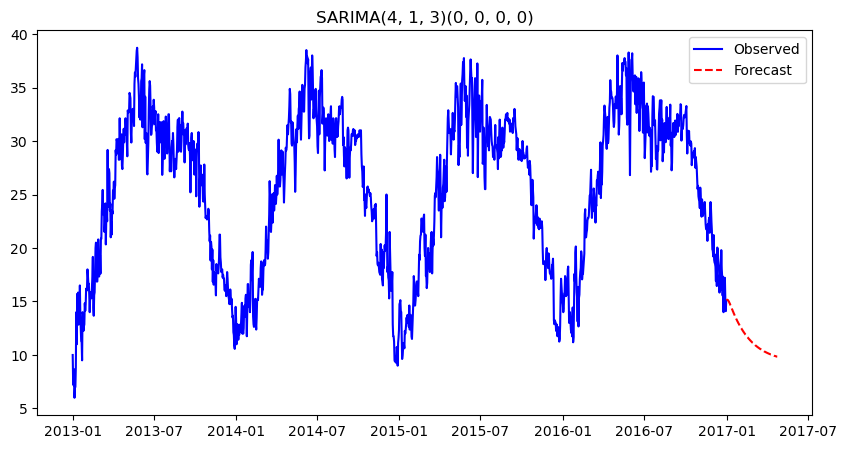

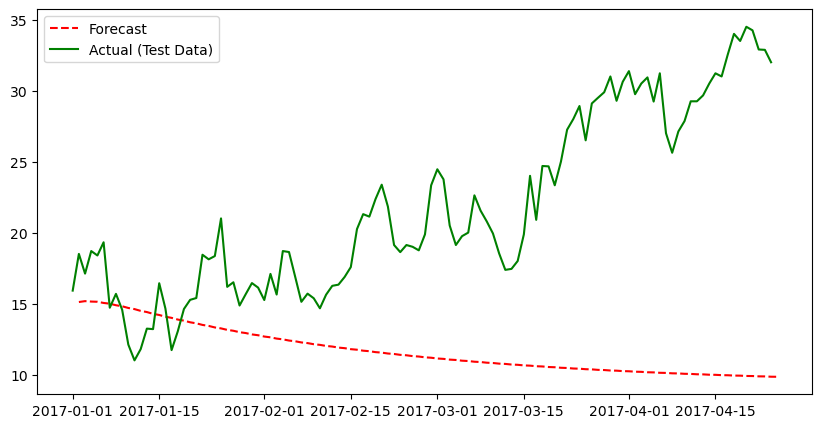

Mean of the Error: 10.012928681439409
MSE: 159.21299895486044
Variance of the Error: 58.95425817526853


In [46]:
chosen_sarima_mean, chosen_sarima_var, chosen_sarima_mse = forcast_and_mean_var_error(chosen_model=chosen_model)

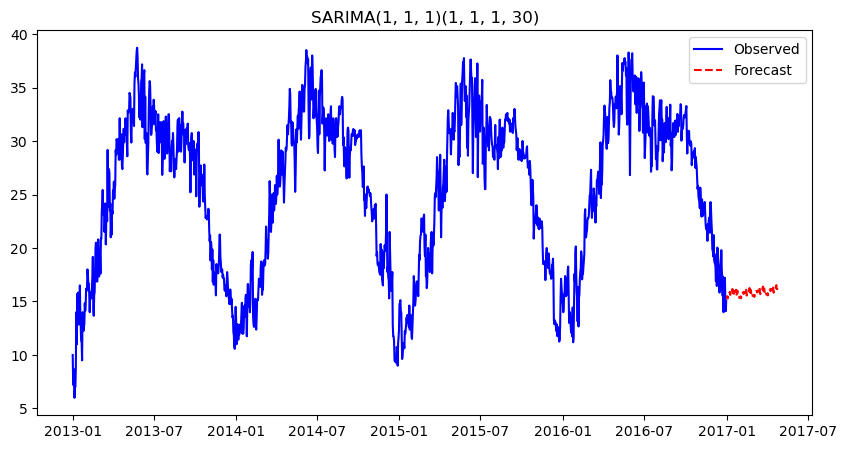

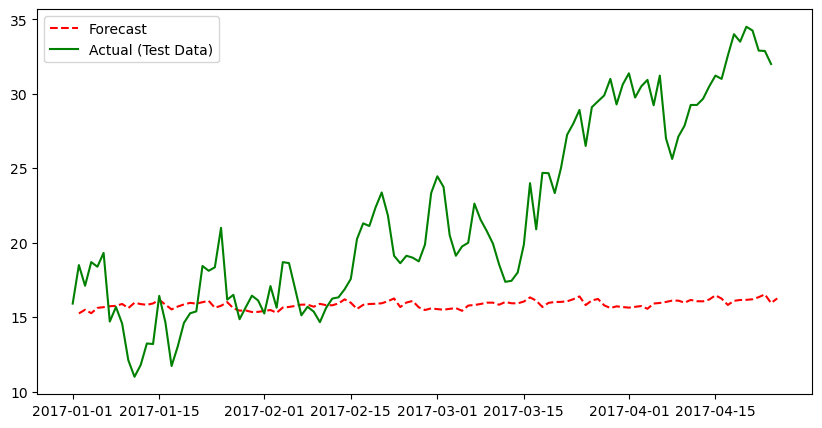

Mean of the Error: 5.853440640287713
MSE: 72.94749339095303
Variance of the Error: 38.68472606158121


In [47]:
sarima_111_mean, sarima_111_var, sarima_111_mse = forcast_and_mean_var_error(chosen_model=model_111_11130)

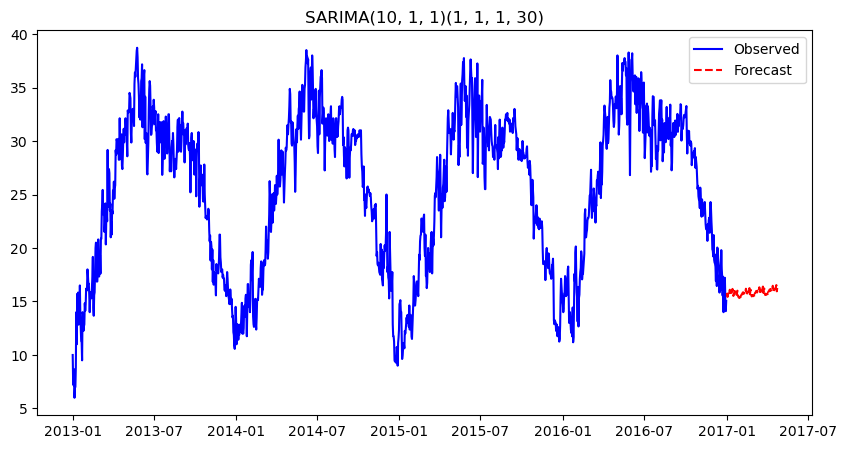

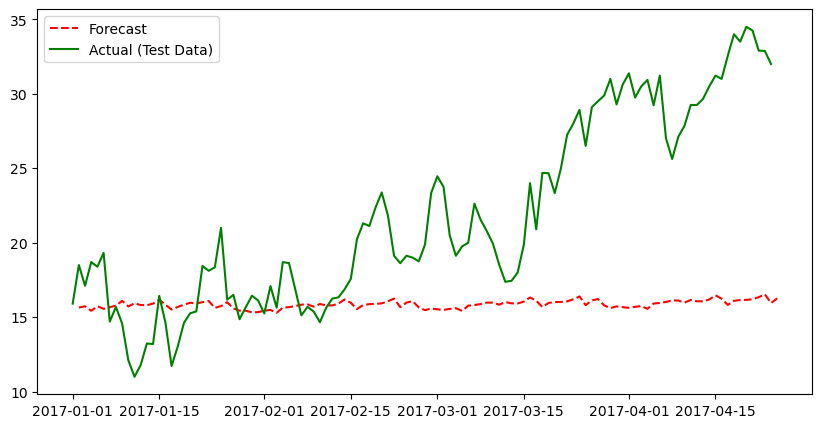

Mean of the Error: 5.849230565719072
MSE: 72.9567513188279
Variance of the Error: 38.74325310788563


In [48]:
sarima_1011_mean, sarima_1011_var, sarima_1011_mse = forcast_and_mean_var_error(chosen_model=model_1011_11130)

## Prophet



In [49]:
df_prophet = df_weather_train.copy()
df_prophet['ds'] = df_weather_train['date']
df_prophet = df_prophet.rename(columns={'meantemp': 'y'})
df_prophet = df_prophet[['ds','y']]
df_prophet.head()

ds          y
0 2013-01-01  10.000000
1 2013-01-02   7.400000
2 2013-01-03   7.166667
3 2013-01-04   8.666667
4 2013-01-05   6.000000

In [50]:
from pickle import TRUE
prophet_model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
prophet_model.fit(df_prophet)

21:06:45 - cmdstanpy - INFO - Chain [1] start processing
21:06:46 - cmdstanpy - INFO - Chain [1] done processing


In [51]:
future = prophet_model.make_future_dataframe(periods=120, freq='D')
forecast = prophet_model.predict(future)

In [52]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

ds       yhat  yhat_lower  yhat_upper
1571 2017-04-21  33.228467   30.623432   35.808722
1572 2017-04-22  33.310729   30.906101   35.911327
1573 2017-04-23  33.379658   30.814119   36.019871
1574 2017-04-24  33.709581   31.165033   36.215110
1575 2017-04-25  33.914228   31.337687   36.517087
1576 2017-04-26  34.178921   31.709783   36.813657
1577 2017-04-27  34.244798   31.662100   36.801266
1578 2017-04-28  34.342568   31.682004   36.847586
1579 2017-04-29  34.375750   31.741480   36.984503
1580 2017-04-30  34.394089   31.773898   37.045200

C:\Users\eliza\AppData\Local\Temp\ipykernel_29520\1031720562.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


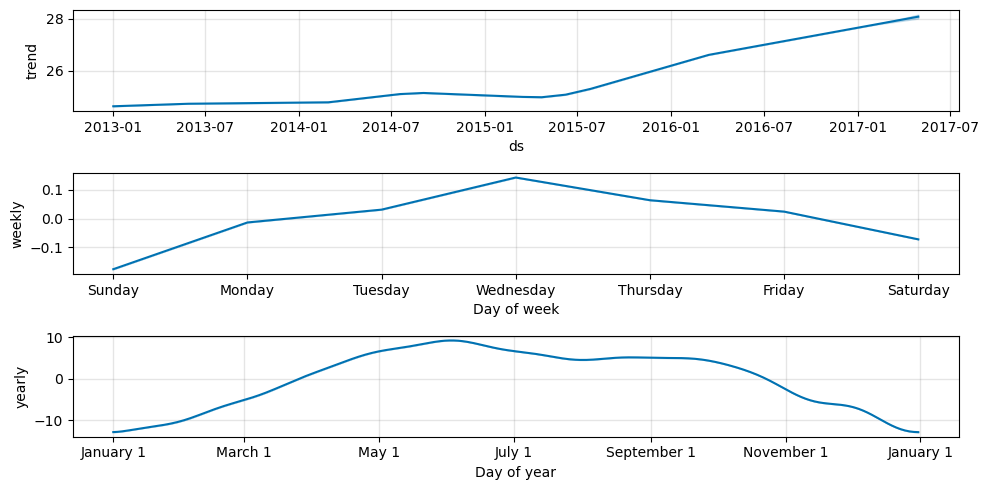

In [53]:
fig = plot_components(prophet_model, forecast, figsize=(10,5))
fig.show()

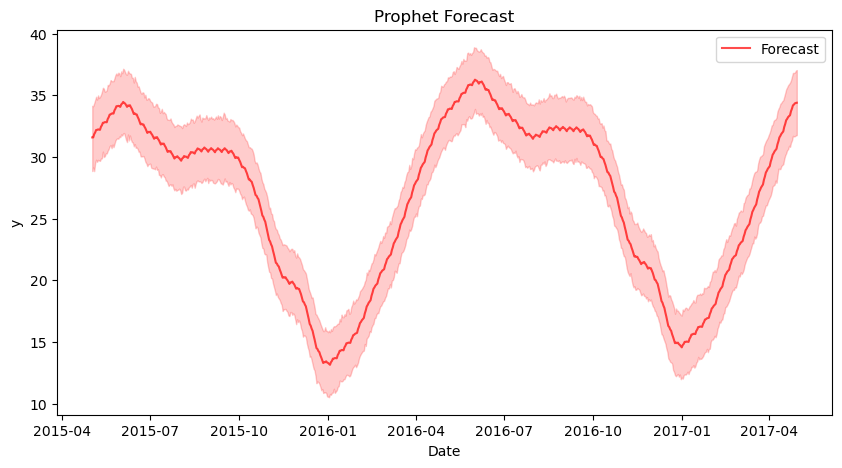

In [54]:
plt.figure(figsize=(10, 5))
plt.plot(forecast['ds'][-730:], forecast['yhat'][-730:], label='Forecast', color='red', alpha=0.7)
plt.fill_between(forecast['ds'][-730:],
                 forecast['yhat_lower'][-730:],
                 forecast['yhat_upper'][-730:],
                 color='red', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('y')
plt.title('Prophet Forecast')
plt.legend()
plt.show()

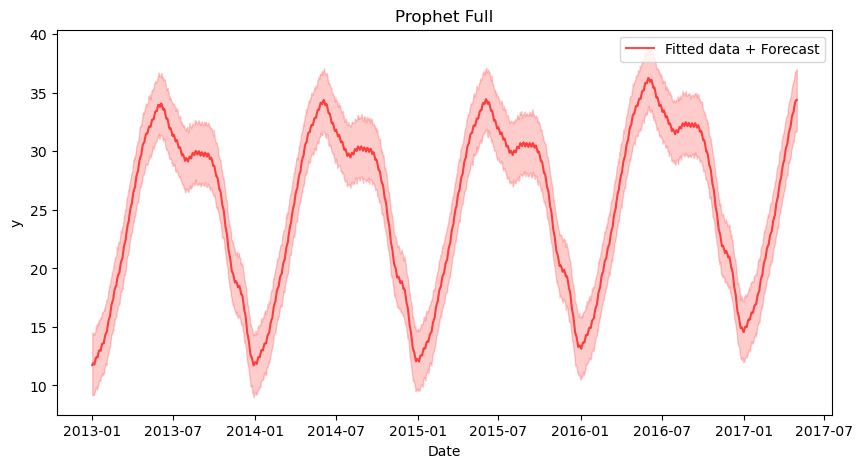

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(forecast['ds'], forecast['yhat'], label='Fitted data + Forecast', color='red', alpha=0.7)
plt.fill_between(forecast['ds'],
                 forecast['yhat_lower'],
                 forecast['yhat_upper'],
                 color='red', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('y')
plt.title('Prophet Full')
plt.legend()
plt.show()

### Comparing the Test to the Prediction


In [56]:
df_weather_test_prophet = df_weather_test.copy()

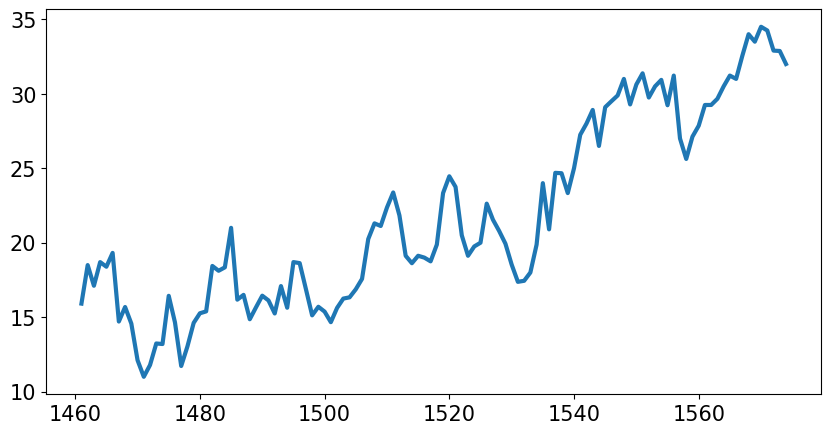

In [57]:
df_weather_test_prophet['meantemp'].plot(figsize=(10,5), linewidth=3, fontsize=15)
plt.show()

In [58]:
print(df_weather_test_prophet.columns)
df_weather_test_prophet.rename(columns={'date': 'ds'}, inplace=True)
print(df_weather_test_prophet.columns)

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')
Index(['ds', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')


In [59]:
df_weather_test_prophet['ds'] = pd.to_datetime(df_weather_test_prophet['ds'], dayfirst=True)
forecast['ds'] = pd.to_datetime(forecast['ds'], dayfirst=True)

In [60]:
df_compare = df_weather_test_prophet.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
                                           on='ds',
                                           how='inner')
df_compare

ds   meantemp   humidity  wind_speed  meanpressure       yhat  \
0   2017-01-01  15.913043  85.869565    2.743478     59.000000  14.562071   
1   2017-01-02  18.500000  77.222222    2.894444   1018.277778  14.754303   
2   2017-01-03  17.111111  81.888889    4.016667   1018.333333  14.842677   
3   2017-01-04  18.700000  70.050000    4.545000   1015.700000  15.010925   
4   2017-01-05  18.388889  74.944444    3.300000   1014.333333  14.998436   
..         ...        ...        ...         ...           ...        ...   
109 2017-04-20  34.500000  27.500000    5.562500    998.625000  33.083935   
110 2017-04-21  34.250000  39.375000    6.962500    999.875000  33.228467   
111 2017-04-22  32.900000  40.900000    8.890000   1001.600000  33.310729   
112 2017-04-23  32.875000  27.500000    9.962500   1002.125000  33.379658   
113 2017-04-24  32.000000  27.142857   12.157143   1004.142857  33.709581   

     yhat_lower  yhat_upper  
0     12.106018   17.148453  
1     12.023565   17.633747  
2     12.306416   17.500868  
3     12.366155   17.687119  
4     12.350079   17.784788  
..          ...         ...  
109   30.549986   35.635136  
110   30.623432   35.808722  
111   30.906101   35.911327  
112   30.814119   36.019871  
113   31.165033   36.215110  

[114 rows x 8 columns]

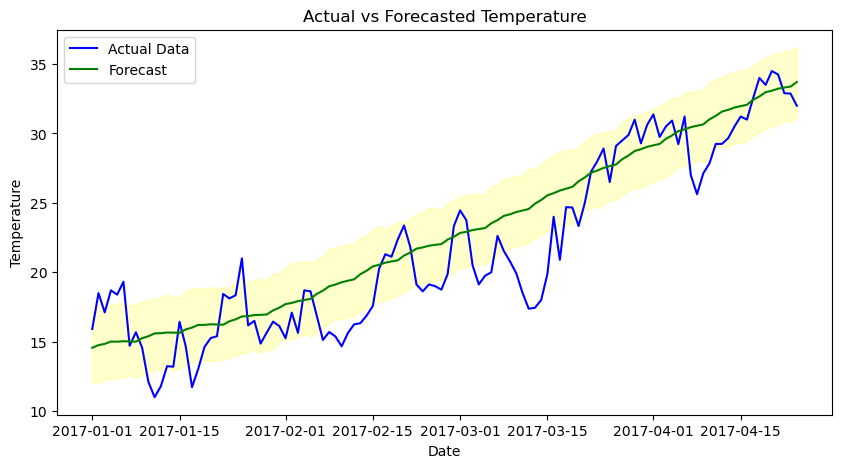

In [61]:
plt.figure(figsize=(10, 5))
plt.plot(df_compare['ds'], df_compare['meantemp'], label='Actual Data',
         color='blue')
plt.plot(df_compare['ds'], df_compare['yhat'], label='Forecast', color='green')
plt.fill_between(df_compare['ds'], df_compare['yhat_lower'],
                 df_compare['yhat_upper'], color='yellow', alpha=0.2)

plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Actual vs Forecasted Temperature')
plt.legend()
plt.show()

In [62]:
prophet_mean, prophet_var, prophet_mse = calculate_mean_and_var(test_values=df_compare['meantemp'], forecast=df_compare['yhat'])

Mean of the Error: -1.183979405953334
MSE: 7.506129087932425
Variance of the Error: 6.104321854210813


## Exponential Smoothing (Holt Winters)


In [63]:
df_HW = df_weather_train.copy()
df_HW.set_index('date', inplace=True)

In [64]:
SES=ExponentialSmoothing(df_HW['meantemp'], seasonal_periods=365, trend='add',
                         seasonal='add')
ses_fit=SES.fit()

C:\Users\eliza\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\eliza\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [65]:
rng = pd.date_range(start = '2013-01-01', end = '2016-12-31', freq='D')

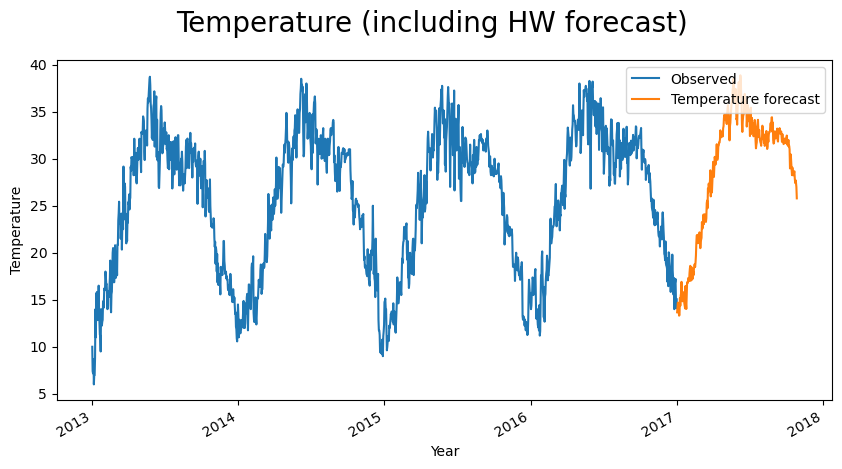

In [66]:
fig,ax = plt.subplots(figsize=(10, 5))
ax.plot(rng, df_HW['meantemp'], label="Observed")
ses_fit.forecast(300).plot(label="Temperature forecast")
ax.set_xlabel("Year")
ax.set_ylabel("Temperature")
ax.legend(loc='upper right')
fig.suptitle("Temperature (including HW forecast)",fontsize=20);
plt.show()

### Comparing the Test to the Prediction

In [67]:
df_weather_test_HW = df_weather_test.copy()
forecast_HW = ses_fit.forecast(steps=len(df_weather_test_HW))

In [68]:
print(df_weather_test_HW.columns)
df_weather_test_HW.rename(columns={'date': 'ds'}, inplace=True)
df_weather_test_HW['ds'] = pd.to_datetime(df_weather_test_HW['ds'], dayfirst=True)
print(df_weather_test_HW.columns)

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')
Index(['ds', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')


In [69]:
forecast_HW_df = pd.DataFrame({'ds': df_weather_test_HW['ds'],
                               'yhat': forecast_HW.values})

In [70]:
df_compare_HW = df_weather_test_HW.merge(forecast_HW_df,
                                         on='ds',
                                         how='inner')

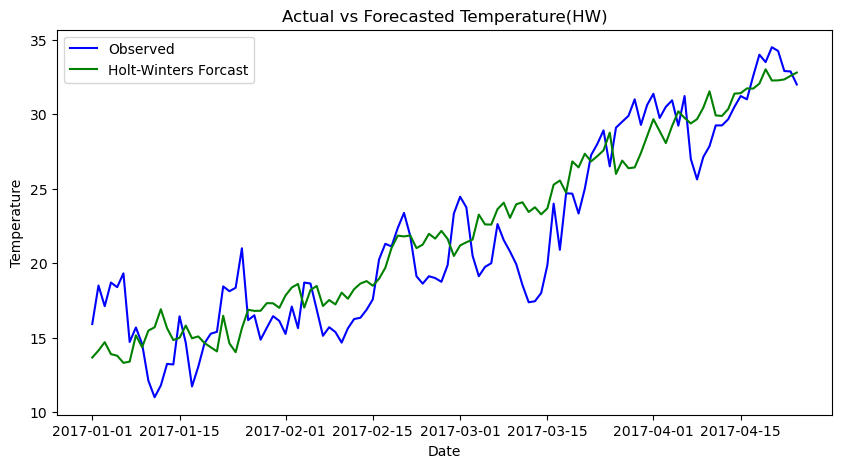

In [71]:
plt.figure(figsize=(10,5))
plt.plot(df_compare_HW['ds'], df_compare_HW['meantemp'], label='Observed',
         color ='blue')
plt.plot(df_compare_HW['ds'], df_compare_HW['yhat'],
         label='Holt-Winters Forcast', color ='green')

plt.title('Actual vs Forecasted Temperature(HW)')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [72]:
HW_mean, HW_var, HW_mse = calculate_mean_and_var(test_values=df_compare_HW['meantemp'], forecast=df_compare_HW['yhat'])

Mean of the Error: -0.4925017935774354
MSE: 7.078688193641354
Variance of the Error: 6.836130176964364


In [73]:
print(
f"Model        | Mean              |  Var              | MSE  \n"
f"SARIMA:        {sarima_1011_mean}| {sarima_1011_var}| {sarima_1011_mse} \n"
f"Prophet:       {prophet_mean}| {prophet_var} | {prophet_mse} \n"
f"Holt Winters: {HW_mean}| {HW_var}  | {HW_mse}")

Model        | Mean              |  Var              | MSE  
SARIMA:        5.849230565719072| 38.74325310788563| 72.9567513188279 
Prophet:       -1.183979405953334| 6.104321854210813 | 7.506129087932425 
Holt Winters: -0.4925017935774354| 6.836130176964364  | 7.078688193641354


We get the the Prophet model seems to be the best even though it doesn't successed to identify peaks.

# Part 3


In [74]:
df_prophet_exogenous = df_weather_train.copy()
df_prophet_exogenous.set_index('date',inplace=True)
print(df_prophet_exogenous.columns)

Index(['meantemp', 'humidity', 'wind_speed', 'meanpressure', 'Year'], dtype='object')


In [75]:
df_prophet_exogenous = df_prophet_exogenous.rename(columns={'meantemp': 'y', 'humidity': 'humidity', 'wind_speed': 'wind_speed'})
df_prophet_exogenous['ds'] = df_prophet_exogenous.index
df_prophet_exogenous.head()

y   humidity  wind_speed  meanpressure  Year         ds
date                                                                       
2013-01-01  10.000000  84.500000    0.000000   1015.666667  2013 2013-01-01
2013-01-02   7.400000  92.000000    2.980000   1017.800000  2013 2013-01-02
2013-01-03   7.166667  87.000000    4.633333   1018.666667  2013 2013-01-03
2013-01-04   8.666667  71.333333    1.233333   1017.166667  2013 2013-01-04
2013-01-05   6.000000  86.833333    3.700000   1016.500000  2013 2013-01-05

In [76]:
model_exogenous = Prophet(daily_seasonality=False,weekly_seasonality=True, yearly_seasonality=True)
model_exogenous.add_regressor('humidity')
model_exogenous.add_regressor('wind_speed')

In [77]:
model_exogenous.fit(df_prophet_exogenous)

21:07:06 - cmdstanpy - INFO - Chain [1] start processing
21:07:06 - cmdstanpy - INFO - Chain [1] done processing


In [78]:
df_prophet_exogenous_test = df_weather_test.copy()
df_prophet_exogenous_test['ds'] = df_prophet_exogenous_test['date']
df_prophet_exogenous_test.set_index('date', inplace=True)
df_prophet_exogenous_test.head()

meantemp   humidity  wind_speed  meanpressure         ds
date                                                                 
2017-01-01  15.913043  85.869565    2.743478     59.000000 2017-01-01
2017-01-02  18.500000  77.222222    2.894444   1018.277778 2017-01-02
2017-01-03  17.111111  81.888889    4.016667   1018.333333 2017-01-03
2017-01-04  18.700000  70.050000    4.545000   1015.700000 2017-01-04
2017-01-05  18.388889  74.944444    3.300000   1014.333333 2017-01-05

In [79]:
df_prophet_exogenous.tail()

y   humidity  wind_speed  meanpressure  Year         ds
date                                                                       
2016-12-27  16.850000  67.550000    8.335000   1017.200000  2016 2016-12-27
2016-12-28  17.217391  68.043478    3.547826   1015.565217  2016 2016-12-28
2016-12-29  15.238095  87.857143    6.000000   1016.904762  2016 2016-12-29
2016-12-30  14.095238  89.666667    6.266667   1017.904762  2016 2016-12-30
2016-12-31  15.052632  87.000000    7.325000   1016.100000  2016 2016-12-31

In [80]:
df_prophet_exogenous_test.shape

(114, 5)

In [81]:
future_exognous = model_exogenous.make_future_dataframe(periods=114, freq='D')
future_exognous['humidity'] = pd.concat([df_prophet_exogenous['humidity'].reset_index(drop=True), df_prophet_exogenous_test['humidity'].reset_index(drop=True)], axis=0).reset_index(drop=True)
future_exognous['wind_speed'] = pd.concat([df_prophet_exogenous['wind_speed'].reset_index(drop=True), df_prophet_exogenous_test['wind_speed'].reset_index(drop=True)], axis=0).reset_index(drop=True)

future_exognous

ds   humidity  wind_speed
0    2013-01-01  84.500000    0.000000
1    2013-01-02  92.000000    2.980000
2    2013-01-03  87.000000    4.633333
3    2013-01-04  71.333333    1.233333
4    2013-01-05  86.833333    3.700000
...         ...        ...         ...
1570 2017-04-20  27.500000    5.562500
1571 2017-04-21  39.375000    6.962500
1572 2017-04-22  40.900000    8.890000
1573 2017-04-23  27.500000    9.962500
1574 2017-04-24  27.142857   12.157143

[1575 rows x 3 columns]

In [82]:
part3_exognous = model_exogenous.predict(future_exognous)

C:\Users\eliza\AppData\Local\Temp\ipykernel_29520\2548001268.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


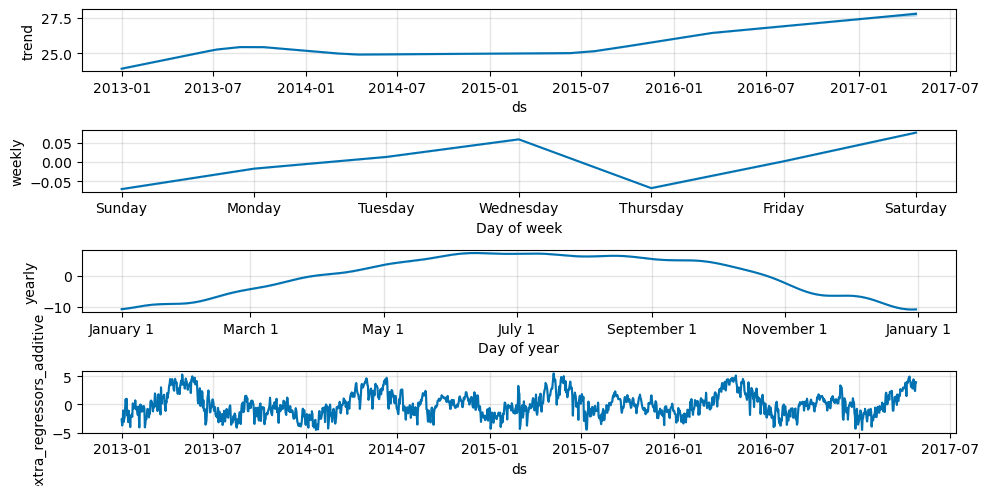

In [83]:
fig = plot_components(model_exogenous, part3_exognous, figsize=(10,5))
fig.show()

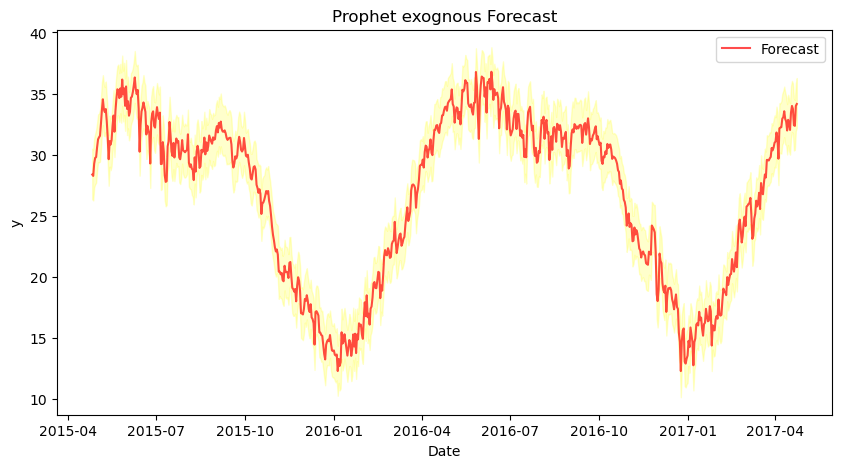

In [84]:
plt.figure(figsize=(10, 5))
plt.plot(part3_exognous['ds'][-730:], part3_exognous['yhat'][-730:], label='Forecast', color='red', alpha=0.7)
plt.fill_between(part3_exognous['ds'][-730:],
                 part3_exognous['yhat_lower'][-730:],
                 part3_exognous['yhat_upper'][-730:],
                 color='yellow', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('y')
plt.title('Prophet exognous Forecast')
plt.legend()
plt.show()

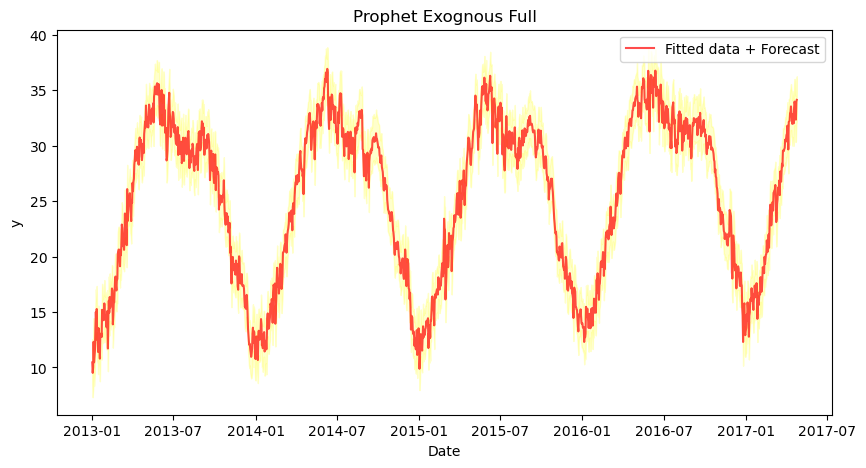

In [85]:
plt.figure(figsize=(10, 5))
plt.plot(part3_exognous['ds'], part3_exognous['yhat'], label='Fitted data + Forecast', color='red', alpha=0.7)
plt.fill_between(part3_exognous['ds'],
                 part3_exognous['yhat_lower'],
                 part3_exognous['yhat_upper'],
                 color='yellow', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('y')
plt.title('Prophet Exognous Full')
plt.legend()
plt.show()


### Comparing the Test to the Prediction



In [86]:
part3_exognous['ds'] = pd.to_datetime(part3_exognous['ds'], dayfirst=True)
# part3_exognous['ds']

In [87]:
df_compare_exognous = df_prophet_exogenous_test.merge(
    part3_exognous[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    on='ds', how='inner')

df_compare_exognous

meantemp   humidity  wind_speed  meanpressure         ds       yhat  \
0    15.913043  85.869565    2.743478     59.000000 2017-01-01  13.571008   
1    18.500000  77.222222    2.894444   1018.277778 2017-01-02  14.774285   
2    17.111111  81.888889    4.016667   1018.333333 2017-01-03  14.262506   
3    18.700000  70.050000    4.545000   1015.700000 2017-01-04  15.868218   
4    18.388889  74.944444    3.300000   1014.333333 2017-01-05  15.299080   
..         ...        ...         ...           ...        ...        ...   
109  34.500000  27.500000    5.562500    998.625000 2017-04-20  33.739481   
110  34.250000  39.375000    6.962500    999.875000 2017-04-21  32.409771   
111  32.900000  40.900000    8.890000   1001.600000 2017-04-22  32.358487   
112  32.875000  27.500000    9.962500   1002.125000 2017-04-23  33.990784   
113  32.000000  27.142857   12.157143   1004.142857 2017-04-24  34.145594   

     yhat_lower  yhat_upper  
0     11.328609   15.682579  
1     12.733402   16.862302  
2     12.170281   16.265974  
3     13.985882   17.849411  
4     13.428506   17.535557  
..          ...         ...  
109   31.740073   35.829404  
110   30.339118   34.612759  
111   30.398004   34.479747  
112   31.936603   35.865748  
113   32.195349   36.268352  

[114 rows x 8 columns]

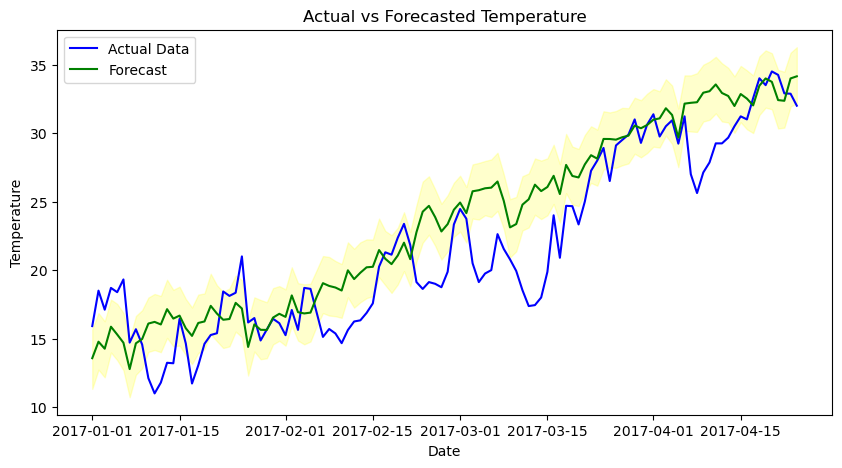

In [88]:
plt.figure(figsize=(10, 5))
plt.plot(df_compare_exognous['ds'], df_compare_exognous['meantemp'], label='Actual Data', color='blue')
plt.plot(df_compare_exognous['ds'], df_compare_exognous['yhat'], label='Forecast', color='green')
plt.fill_between(df_compare_exognous['ds'], df_compare_exognous['yhat_lower'],
                 df_compare_exognous['yhat_upper'], color='yellow', alpha=0.2)


plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Actual vs Forecasted Temperature')
plt.legend()
plt.show()


In [90]:
error = df_prophet_exogenous_test['meantemp'] - part3_exognous['yhat'][-114:].values
error_mean = np.mean(error)
mse = np.mean(np.power(error,2))
error_variance = np.var(error)

print(f"Mean of the Error: {error_mean}")
print(f"MSE: {mse}")
print(f"Variance of the Error: {error_variance}")

Mean of the Error: -1.7706456222719984
MSE: 10.66516674803861
Variance of the Error: 7.52998082836762


We looked at both the Humidity and the wind speed. Since the model seems to work less well, we will check with each parameter seperatly.

In [91]:
# ONLY Humidity
model_exogenous_humidity = Prophet(daily_seasonality=False,weekly_seasonality=True, yearly_seasonality=True)
model_exogenous_humidity.add_regressor('humidity')
model_exogenous_humidity.fit(df_prophet_exogenous)

21:09:16 - cmdstanpy - INFO - Chain [1] start processing
21:09:16 - cmdstanpy - INFO - Chain [1] done processing


In [92]:
future_exognous_h = model_exogenous_humidity.make_future_dataframe(periods=114, freq='D')
future_exognous_h['humidity'] = pd.concat([df_prophet_exogenous['humidity'].reset_index(drop=True), df_prophet_exogenous_test['humidity'].reset_index(drop=True)], axis=0).reset_index(drop=True)

part3_exognous_h = model_exogenous_humidity.predict(future_exognous_h)

C:\Users\eliza\AppData\Local\Temp\ipykernel_29520\4022957851.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


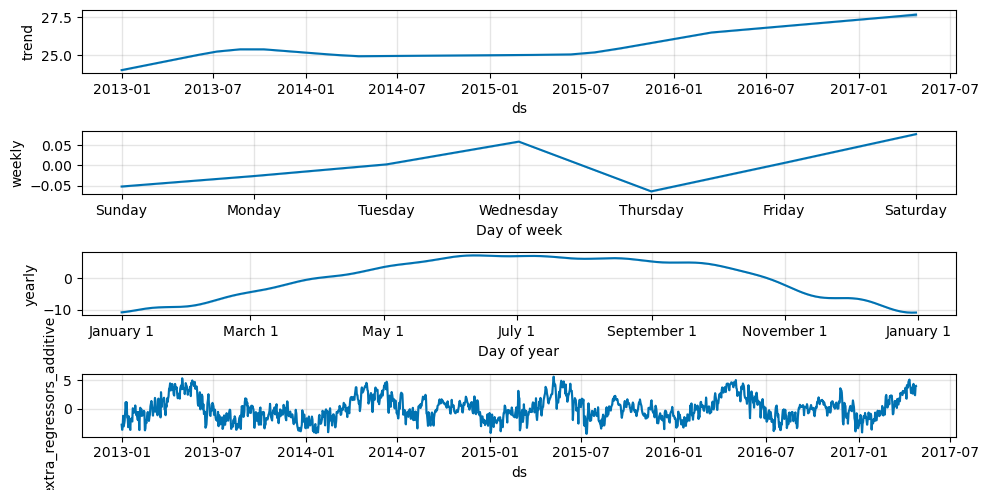

In [93]:
fig = plot_components(model_exogenous_humidity, part3_exognous_h, figsize=(10,5))
fig.show()

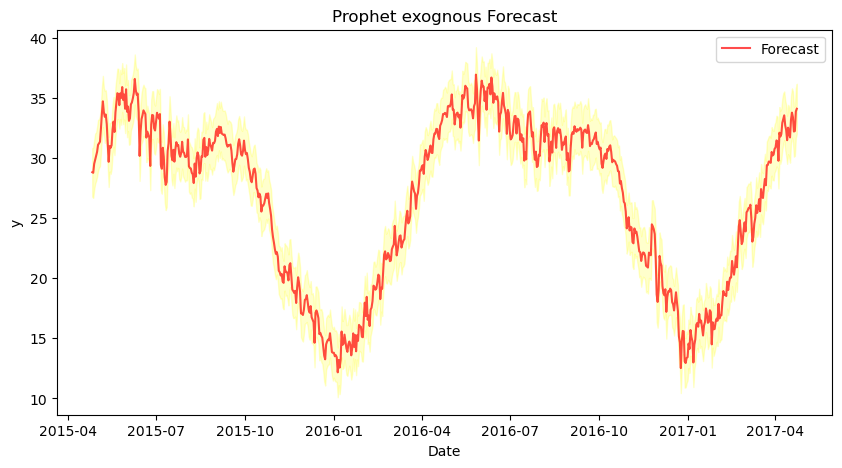

In [94]:
plt.figure(figsize=(10, 5))
plt.plot(part3_exognous_h['ds'][-730:], part3_exognous_h['yhat'][-730:], label='Forecast', color='red', alpha=0.7)
plt.fill_between(part3_exognous_h['ds'][-730:],
                 part3_exognous_h['yhat_lower'][-730:],
                 part3_exognous_h['yhat_upper'][-730:],
                 color='yellow', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('y')
plt.title('Prophet exognous Forecast')
plt.legend()
plt.show()

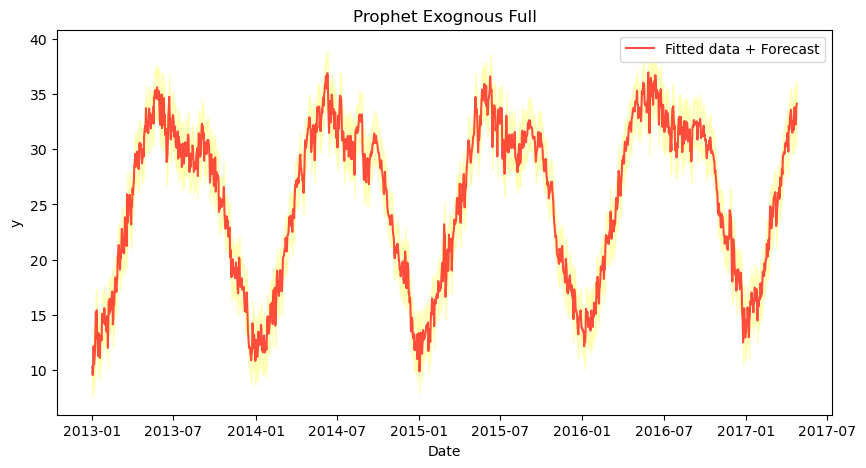

In [95]:
plt.figure(figsize=(10, 5))
plt.plot(part3_exognous_h['ds'], part3_exognous_h['yhat'], label='Fitted data + Forecast', color='red', alpha=0.7)
plt.fill_between(part3_exognous_h['ds'],
                 part3_exognous_h['yhat_lower'],
                 part3_exognous_h['yhat_upper'],
                 color='yellow', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('y')
plt.title('Prophet Exognous Full')
plt.legend()
plt.show()

In [96]:
part3_exognous_h['ds'] = pd.to_datetime(part3_exognous_h['ds'], dayfirst=True)

In [97]:
df_compare_exognous_h = df_prophet_exogenous_test.merge(
    part3_exognous_h[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    on='ds', how='inner')

df_compare_exognous_h

meantemp   humidity  wind_speed  meanpressure         ds       yhat  \
0    15.913043  85.869565    2.743478     59.000000 2017-01-01  13.429201   
1    18.500000  77.222222    2.894444   1018.277778 2017-01-02  14.559310   
2    17.111111  81.888889    4.016667   1018.333333 2017-01-03  14.121002   
3    18.700000  70.050000    4.545000   1015.700000 2017-01-04  15.690482   
4    18.388889  74.944444    3.300000   1014.333333 2017-01-05  15.096273   
..         ...        ...         ...           ...        ...        ...   
109  34.500000  27.500000    5.562500    998.625000 2017-04-20  33.406471   
110  34.250000  39.375000    6.962500    999.875000 2017-04-21  32.211307   
111  32.900000  40.900000    8.890000   1001.600000 2017-04-22  32.255059   
112  32.875000  27.500000    9.962500   1002.125000 2017-04-23  33.879483   
113  32.000000  27.142857   12.157143   1004.142857 2017-04-24  34.105873   

     yhat_lower  yhat_upper  
0     11.495136   15.369638  
1     12.533032   16.567414  
2     12.131966   16.208729  
3     13.568159   17.617998  
4     13.075171   17.020779  
..          ...         ...  
109   31.359523   35.557593  
110   30.115388   34.291543  
111   30.190555   34.363905  
112   31.683181   35.853029  
113   32.000748   36.189476  

[114 rows x 8 columns]

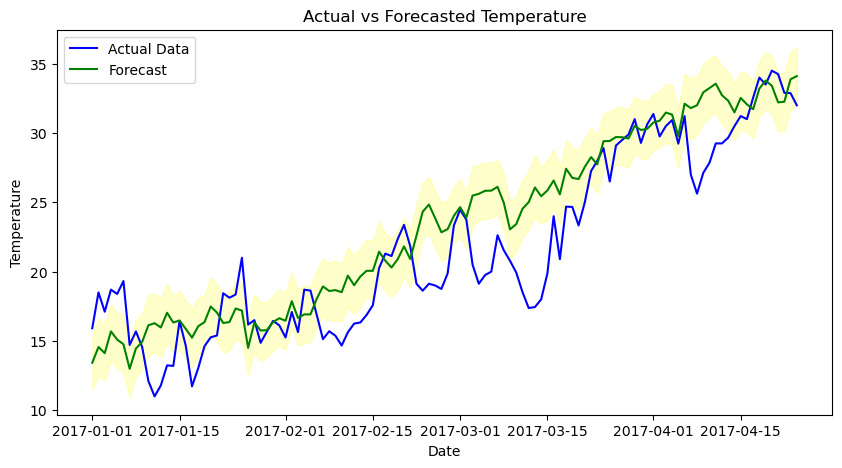

In [98]:
plt.figure(figsize=(10, 5))
plt.plot(df_compare_exognous_h['ds'], df_compare_exognous_h['meantemp'], label='Actual Data', color='blue')
plt.plot(df_compare_exognous_h['ds'], df_compare_exognous_h['yhat'], label='Forecast', color='green')
plt.fill_between(df_compare_exognous_h['ds'], df_compare_exognous_h['yhat_lower'],
                 df_compare_exognous_h['yhat_upper'], color='yellow', alpha=0.2)


plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Actual vs Forecasted Temperature')
plt.legend()
plt.show()

In [100]:
error = df_prophet_exogenous_test['meantemp'] - part3_exognous_h['yhat'][-114:].values
error_mean = np.mean(error)
mse = np.mean(np.power(error,2))
error_variance = np.var(error)

print(f"Mean of the Error: {error_mean}")
print(f"MSE: {mse}")
print(f"Variance of the Error: {error_variance}")

Mean of the Error: -1.6506411209877248
MSE: 10.19792922350091
Variance of the Error: 7.473313113205303


In [101]:
# ONLY wind speed
model_exogenous_wind = Prophet(daily_seasonality=False,weekly_seasonality=True, yearly_seasonality=True)
model_exogenous_wind.add_regressor('wind_speed')
model_exogenous_wind.fit(df_prophet_exogenous)

21:09:28 - cmdstanpy - INFO - Chain [1] start processing
21:09:28 - cmdstanpy - INFO - Chain [1] done processing


In [102]:
future_exognous_w = model_exogenous_wind.make_future_dataframe(periods=114, freq='D')
future_exognous_w['wind_speed'] = pd.concat([df_prophet_exogenous['wind_speed'].reset_index(drop=True), df_prophet_exogenous_test['wind_speed'].reset_index(drop=True)], axis=0).reset_index(drop=True)

part3_exognous_w = model_exogenous_wind.predict(future_exognous_w)

C:\Users\eliza\AppData\Local\Temp\ipykernel_29520\3860013882.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


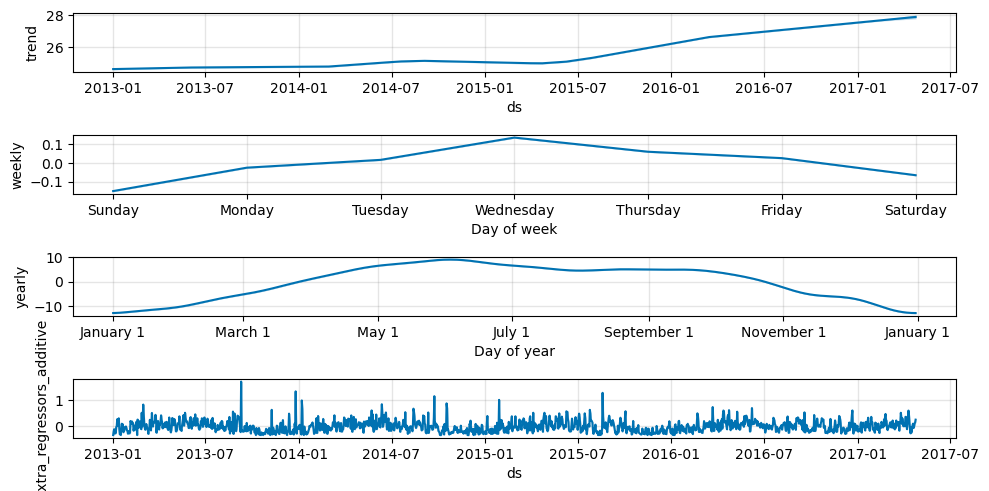

In [103]:
fig = plot_components(model_exogenous_wind, part3_exognous_w, figsize=(10,5))
fig.show()

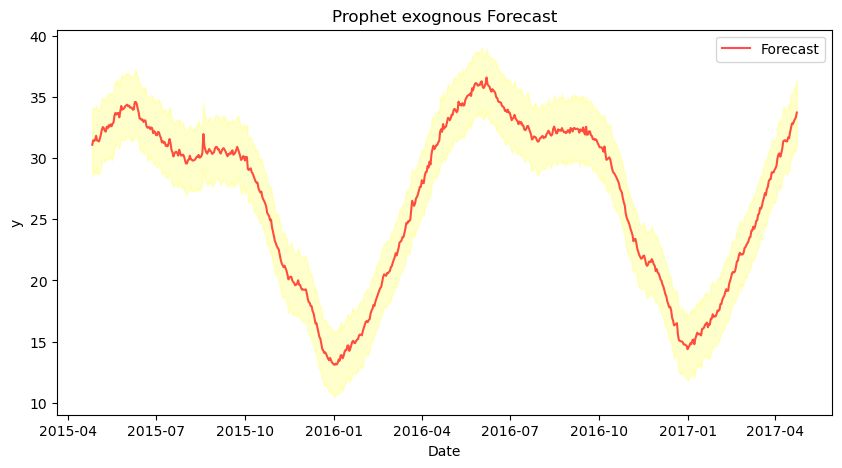

In [104]:
plt.figure(figsize=(10, 5))
plt.plot(part3_exognous_w['ds'][-730:], part3_exognous_w['yhat'][-730:], label='Forecast', color='red', alpha=0.7)
plt.fill_between(part3_exognous_w['ds'][-730:],
                 part3_exognous_w['yhat_lower'][-730:],
                 part3_exognous_w['yhat_upper'][-730:],
                 color='yellow', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('y')
plt.title('Prophet exognous Forecast')
plt.legend()
plt.show()

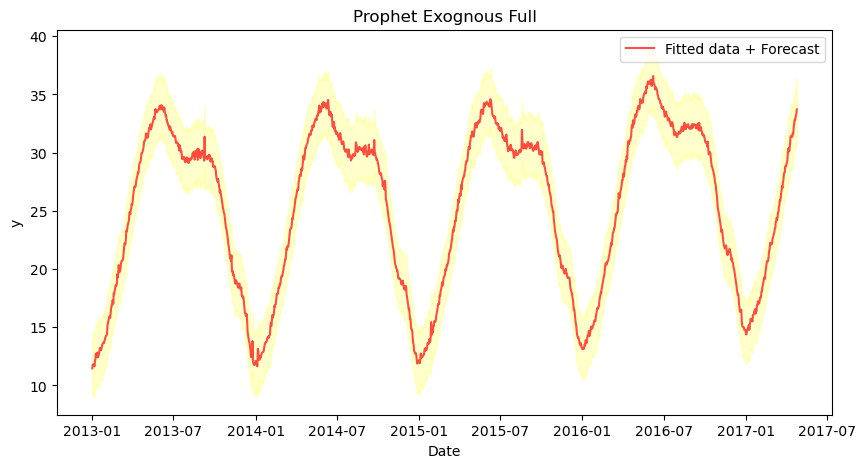

In [105]:
plt.figure(figsize=(10, 5))
plt.plot(part3_exognous_w['ds'], part3_exognous_w['yhat'], label='Fitted data + Forecast', color='red', alpha=0.7)
plt.fill_between(part3_exognous_w['ds'],
                 part3_exognous_w['yhat_lower'],
                 part3_exognous_w['yhat_upper'],
                 color='yellow', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('y')
plt.title('Prophet Exognous Full')
plt.legend()
plt.show()

In [106]:
part3_exognous_w['ds'] = pd.to_datetime(part3_exognous_w['ds'], dayfirst=True)

In [107]:
df_compare_exognous_w = df_prophet_exogenous_test.merge(
    part3_exognous_w[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    on='ds', how='inner')

df_compare_exognous_w

meantemp   humidity  wind_speed  meanpressure         ds       yhat  \
0    15.913043  85.869565    2.743478     59.000000 2017-01-01  14.369008   
1    18.500000  77.222222    2.894444   1018.277778 2017-01-02  14.532613   
2    17.111111  81.888889    4.016667   1018.333333 2017-01-03  14.674004   
3    18.700000  70.050000    4.545000   1015.700000 2017-01-04  14.877332   
4    18.388889  74.944444    3.300000   1014.333333 2017-01-05  14.808939   
..         ...        ...         ...           ...        ...        ...   
109  34.500000  27.500000    5.562500    998.625000 2017-04-20  32.776169   
110  34.250000  39.375000    6.962500    999.875000 2017-04-21  32.995436   
111  32.900000  40.900000    8.890000   1001.600000 2017-04-22  33.177568   
112  32.875000  27.500000    9.962500   1002.125000 2017-04-23  33.318865   
113  32.000000  27.142857   12.157143   1004.142857 2017-04-24  33.720060   

     yhat_lower  yhat_upper  
0     11.804564   16.964409  
1     11.886312   17.226503  
2     12.135885   17.238222  
3     12.334170   17.545503  
4     12.166920   17.372881  
..          ...         ...  
109   30.227253   35.329581  
110   30.729625   35.671512  
111   30.516301   35.785327  
112   30.593017   35.971178  
113   31.112549   36.390639  

[114 rows x 8 columns]

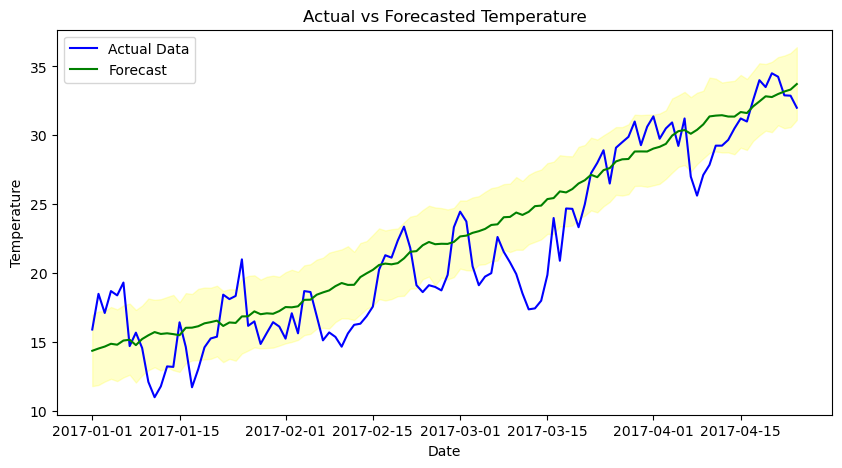

In [108]:
plt.figure(figsize=(10, 5))
plt.plot(df_compare_exognous_w['ds'], df_compare_exognous_w['meantemp'], label='Actual Data', color='blue')
plt.plot(df_compare_exognous_w['ds'], df_compare_exognous_w['yhat'], label='Forecast', color='green')
plt.fill_between(df_compare_exognous_w['ds'], df_compare_exognous_w['yhat_lower'],
                 df_compare_exognous_w['yhat_upper'], color='yellow', alpha=0.2)


plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Actual vs Forecasted Temperature')
plt.legend()
plt.show()

In [110]:
error = df_prophet_exogenous_test['meantemp'] - part3_exognous_w['yhat'][-114:].values
error_mean = np.mean(error)
mse = np.mean(np.power(error,2))
error_variance = np.var(error)

print(f"Mean of the Error: {error_mean}")
print(f"MSE: {mse}")
print(f"Variance of the Error: {error_variance}")

Mean of the Error: -1.1118638378776298
MSE: 7.404411182236734
Variance of the Error: 6.1681699882567615


# Part 4

Since out data isn't Normal, we desided to use the CUSUM method, which doesn't require any assumtions on the distrabution

In [111]:
yhat_df = ses_fit.fittedvalues
y_df = df_HW['meantemp']

residuals = yhat_df - y_df

In [112]:
# are the residuals stationary?
ADFTest(residuals)

ADF Statistic: -12.196937229965874
p-value: 1.2483416735124788e-22
Critical Values: {'1%': -3.434911997169608, '5%': -2.863554810504947, '10%': -2.567842671398422}
The time series is **stationary** (reject null hypothesis).


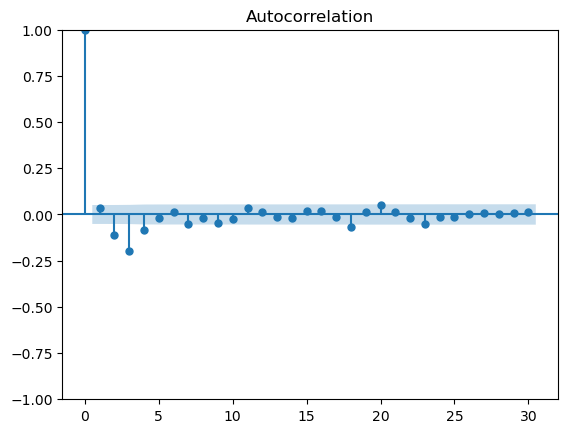

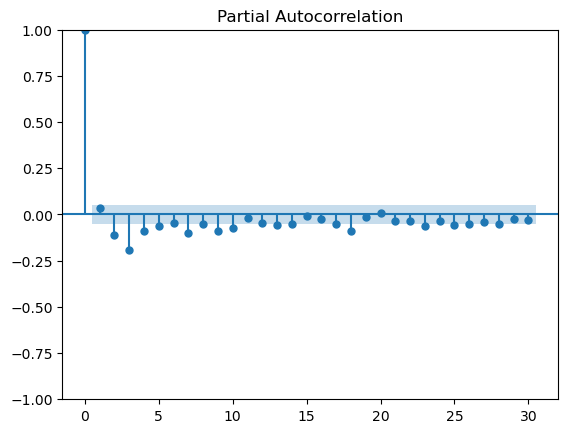

In [113]:
tsaplots.plot_acf(residuals,lags=30);
tsaplots.plot_pacf(residuals,lags=30);

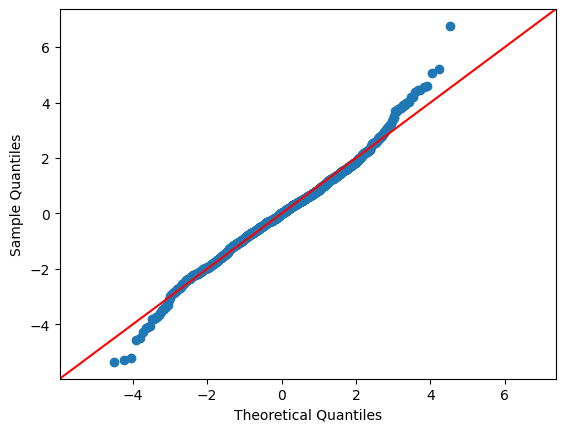

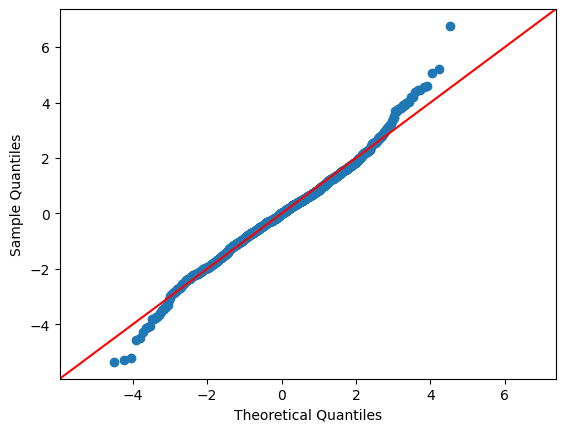

In [114]:
import statsmodels.api as sm
sm.qqplot(residuals, line='45', loc = np.mean(residuals), scale = np.std(residuals))

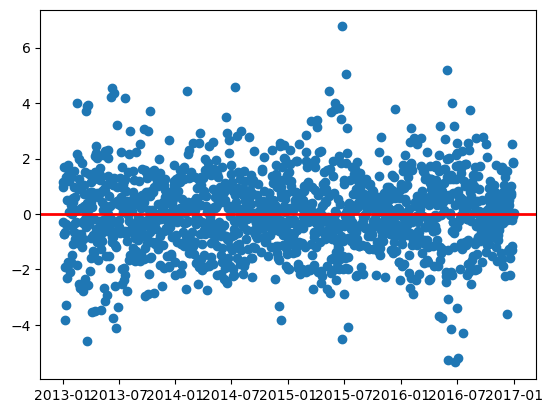

In [115]:
mean = np.mean(residuals)
plt.scatter(residuals.index, residuals)
plt.axhline(y=mean, color='red', linestyle='-', linewidth=2)

In [116]:
def cusum(series, target=None, threshold=3):
    """
    CUSUM algorithm with threshold = 3 * std deviation.

    Parameters:
        series: pd.Series or array-like
            The input time series.
        target: float or None
            The reference value (mean). If None, uses the mean of the series.
        threshold: float
            Number of std deviations for the threshold (default 3).

    Returns:
        pos_cusum: np.array
            Positive cumulative sum values.
        neg_cusum: np.array
            Negative cumulative sum values.
        signals: list of indices where a shift is detected.
    """
    series = np.asarray(series)
    if target is None:
        target = np.mean(series)

    std = np.std(series)
    h = threshold * std

    pos_cusum = np.zeros(len(series))
    neg_cusum = np.zeros(len(series))
    signals = []

    for t in range(1, len(series)):
        pos_cusum[t] = max(0, pos_cusum[t-1] + series[t] - target)
        neg_cusum[t] = min(0, neg_cusum[t-1] + series[t] - target)

        if pos_cusum[t] > h or abs(neg_cusum[t]) > h:
            signals.append(t)
            # Reset after detection
            pos_cusum[t] = 0
            neg_cusum[t] = 0

    return pos_cusum, neg_cusum, signals, target, std


C:\Users\eliza\AppData\Local\Temp\ipykernel_29520\1906171523.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(residuals.index[cp], residuals[cp], color="red", marker="o", label="Detected Change" if cp == change_points[0] else "")


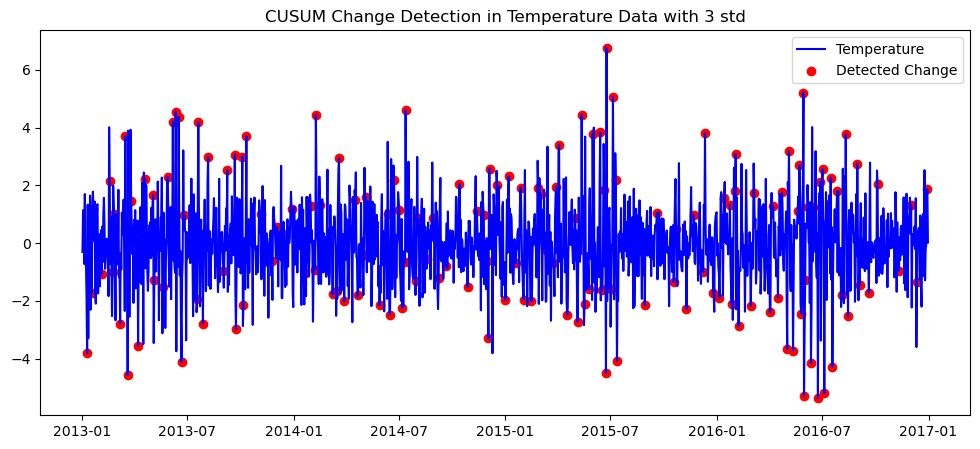

In [117]:
_, _, change_points, mean, std = cusum(residuals)

# Plot results
plt.figure(figsize=(12,5))
plt.plot(residuals.index, residuals, label="Temperature", color="blue")

for cp in change_points:
    plt.scatter(residuals.index[cp], residuals[cp], color="red", marker="o", label="Detected Change" if cp == change_points[0] else "")
plt.legend()
plt.title("CUSUM Change Detection in Temperature Data with 3 std")
plt.show()


C:\Users\eliza\AppData\Local\Temp\ipykernel_29520\1608376076.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(residuals.index[cp], residuals[cp], color="red", marker="o", label="Detected Change" if cp == change_points[0] else "")


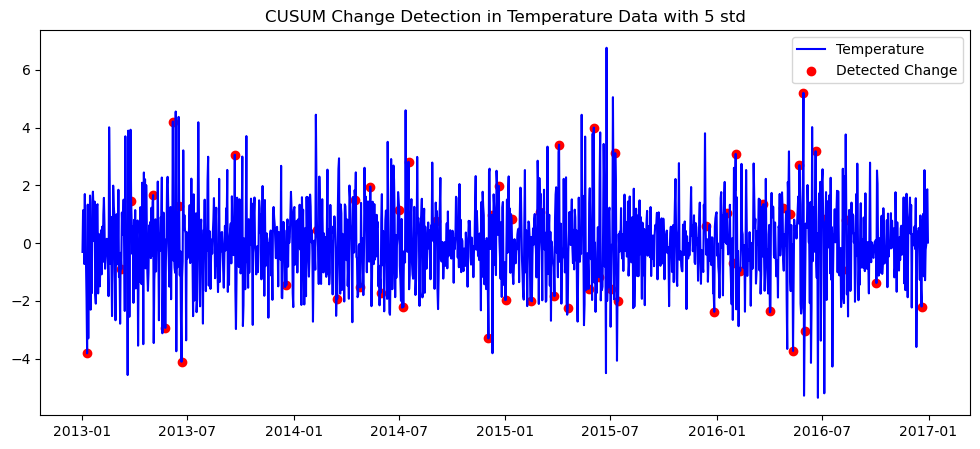

In [118]:
_, _, change_points, mean, std = cusum(residuals, threshold=5)

# Plot results
plt.figure(figsize=(12,5))
plt.plot(residuals.index, residuals, label="Temperature", color="blue")

for cp in change_points:
    plt.scatter(residuals.index[cp], residuals[cp], color="red", marker="o", label="Detected Change" if cp == change_points[0] else "")

plt.legend()
plt.title("CUSUM Change Detection in Temperature Data with 5 std")
plt.show()